# Estimación de la componente estacional, árboles de decisión y redes neruonales para el recaudo de impuestos internos por la DIAN.

En primer lugar para poder realizar el modelo predictivo con arboles de decisión utilizando phyton, nos basaremos en lo encontrado en el análisis descriptivo aplicado utilizando R, y de este modo se realizará la eliminacion de la tendencia, por medio de descomposición STL, luego procederemos  a realizar la estimación de la componente estacional utilizando series de fourier para posteriormente aplicar el modelo de Árboles de decisión y finalizaremos utilizando modelos de redes neuronales mutlicapa y recurrentes. 

In [1]:
!pip install tensorflow 

In [2]:
#importación de las librerias necesarias en las diferentes partes del documento.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression  # solo uso esta en la reg lineal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
import scipy as sp
import scipy.stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

## Carga de los datos. 

In [212]:
## CArga de los datos.
nombre_del_archivo = "dian_phyton.csv"
df = pd.read_csv(nombre_del_archivo,decimal=",")
dian = df.iloc[:, 1:]
dian["Impuestos"]=pd.to_numeric(dian["Impuestos"])
print(dian)

        Impuestos       fecha
0    1.512329e+06  2000-01-01
1    1.100415e+06  2000-02-01
2    1.228774e+06  2000-03-01
3    1.343029e+06  2000-04-01
4    1.293771e+06  2000-05-01
..            ...         ...
277  1.128225e+07  2023-02-01
278  1.611574e+07  2023-03-01
279  2.789091e+07  2023-04-01
280  2.216499e+07  2023-05-01
281  2.337360e+07  2023-06-01

[282 rows x 2 columns]


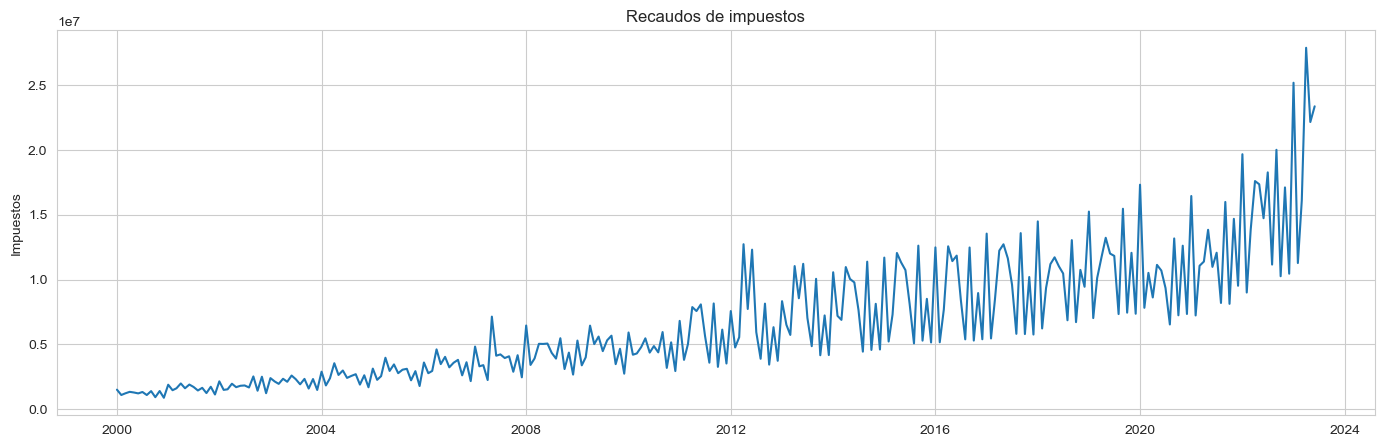

In [213]:
## Gráfico de la serie de tiempo 
dian['fecha']=pd.to_datetime(dian['fecha']) # pasar a formato fecha
Valores_dian=dian.set_index('fecha') # nuevo dataframe indexado por la fecha
Valores_dian['Impuestos'] = pd.to_numeric(Valores_dian['Impuestos'], errors='coerce')
dian_ts=Valores_dian['Impuestos'] # vector con los valores de la serie

plt.plot(dian_ts)
plt.title('Recaudos de impuestos')
plt.ylabel('Impuestos')
plt.show()

Teniendo en cuenta lo elaborado en la parte descriptiva de R, podemos evidenciar que la serie presenta tendencia y tiene presencia de ciclos estacionales con periodo anual (es decir que $s=12$), por lo tanto ajustaremos la varianza teniendo en cuenta que el valor óptimo obtenido en el código de R ($\lambda=0.1$), por esta razon los datos serán transformados utilizando el logaritmo, luego utilizando la estimación via descomposición STL eliminaremos la tendencia y por ultimo vamos a realizar la estimación del ciclo estacional.

## Ajuste de la variabilidad utilizando la transformación box cox.


Nótese que en el código elaborado en R se obtiene un valor óptimo para $\lambda=0.1$, pero como este es cercano a 0, tomaremos el logaritmo de los datos.

In [214]:
Valores_dian.index.freq='MS'
dian_ts.index.freq='MS'#ts.index
sp.stats.boxcox(dian['Impuestos'],alpha=0.05)

(array([35.52496223, 33.95222601, 34.49152152, 34.93106955, 34.74579804,
        34.4718609 , 34.89183865, 33.94439976, 35.13789306, 33.15580725,
        35.15771393, 32.91021848, 36.67136016, 35.37905749, 35.86602767,
        36.92998987, 35.87277114, 36.70557681, 36.18113899, 35.30923856,
        35.97503468, 34.56556822, 36.2224835 , 34.12251889, 37.34328057,
        35.46558058, 35.61426616, 36.8753144 , 36.13208598, 36.4463067 ,
        36.51429367, 36.05892815, 38.19930131, 35.24510942, 38.15122899,
        34.53147955, 37.91738675, 37.30622855, 36.84773285, 37.80471102,
        37.25894192, 38.3435087 , 37.72800988, 36.7530649 , 37.78475651,
        35.8017055 , 37.75691468, 35.44769279, 38.92548146, 36.51840941,
        37.88823128, 40.03992611, 38.43542554, 39.09536491, 37.95582764,
        38.28414557, 38.55239518, 36.69590365, 38.38350308, 36.10637676,
        39.35519766, 37.61915598, 38.24177309, 40.66760851, 39.03275093,
        39.8956531 , 38.70392408, 39.20506679, 39.3

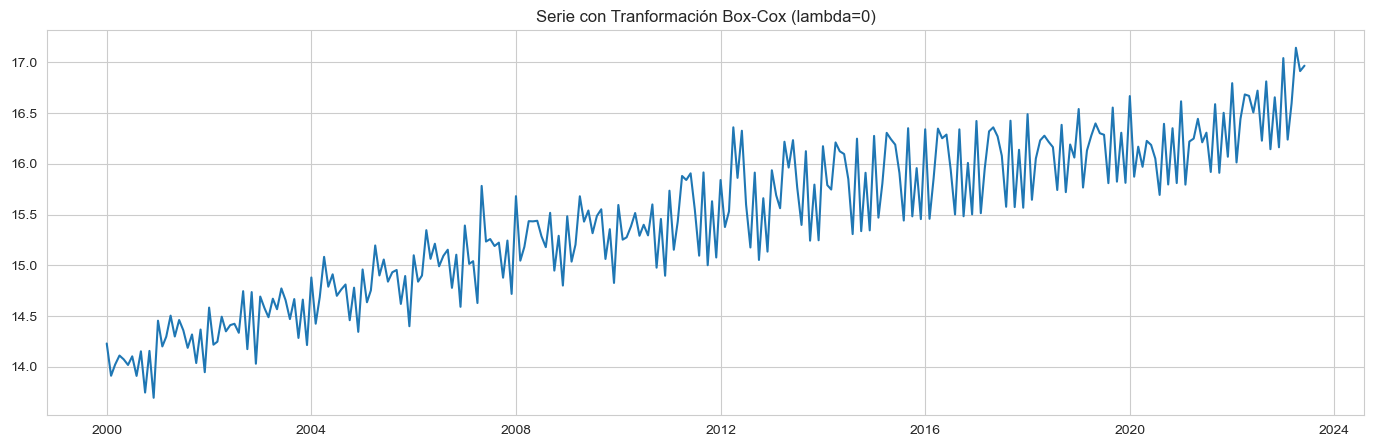

In [215]:
rdian=sp.stats.boxcox(dian['Impuestos'],lmbda=0)
dian = dian.assign(rdian=rdian) # al dataframe original le añadimos los valores de la transformación

rValordian=dian.set_index('fecha')  # Otro dataframe con el índice de la fecha
rdian_Varest= rValordian['rdian'] # la serie de la transformación guardada en el dataframe anterior
plt.plot(rdian_Varest)
plt.title('Serie con Tranformación Box-Cox (lambda=0)')
plt.show()

## Estimación y eliminación de la tendencia 

Teniendo en cuenta lo encontrado en el archivo de R que corresponde a la parte descriptiva de esta serie de tiempo, elegimos utilizar la descomposición STL para la eliminación de la tendencia, por lo tanto, vamos a aplicar la misma metodología para esta sección.

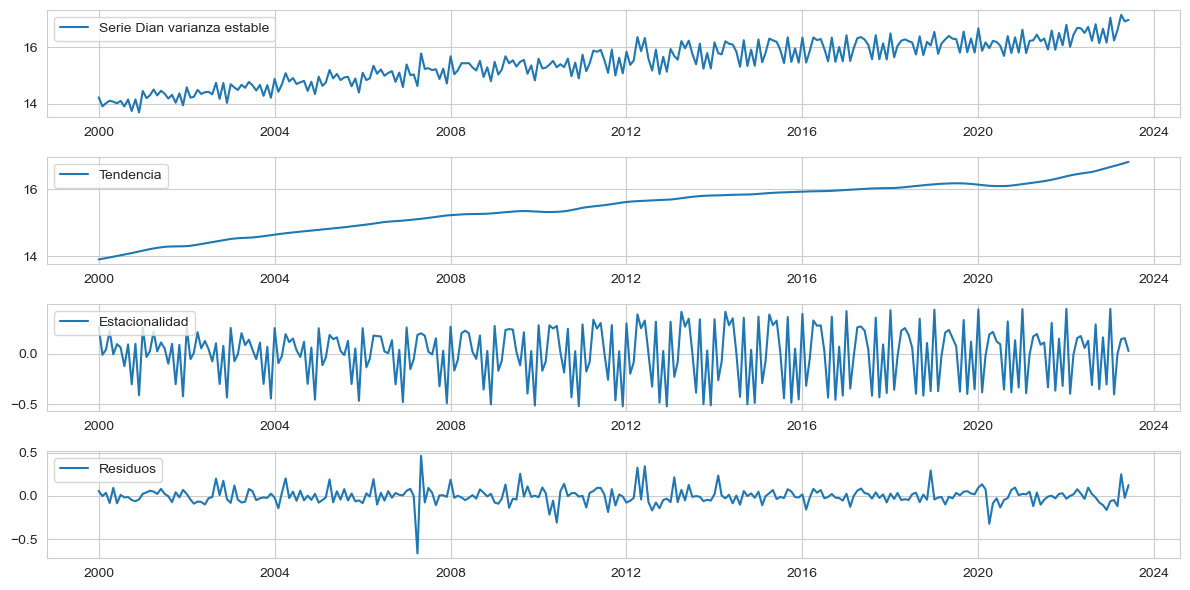

In [216]:
####Descomposición usando STL.
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from matplotlib import pyplot

###También se puede hacer vía STL###
stl = STL(rdian_Varest,seasonal=13)
result = stl.fit()
##Obtención de las componentes
trend_STL = result.trend
seasonal_STL = result.seasonal
residual_STL = result.resid

# Gráfica de las componentes
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(rdian_Varest, label='Serie Dian varianza estable')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend_STL, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal_STL, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual_STL, label='Residuos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [217]:
X1=np.arange(2000,2023.5,1/12)
X=X1

print(X1.shape)
#print(X1)

(282,)


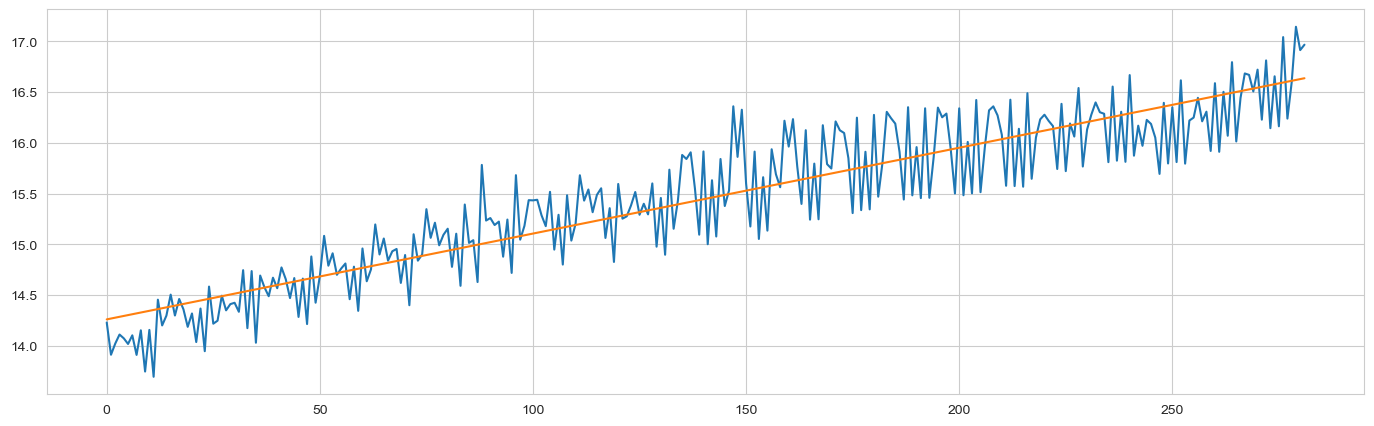

-188.74810617026472

In [218]:
from sklearn.linear_model import LinearRegression
X = np.reshape(X, (len(X), 1))
y =rdian_Varest.values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()
model.coef_
model.intercept_


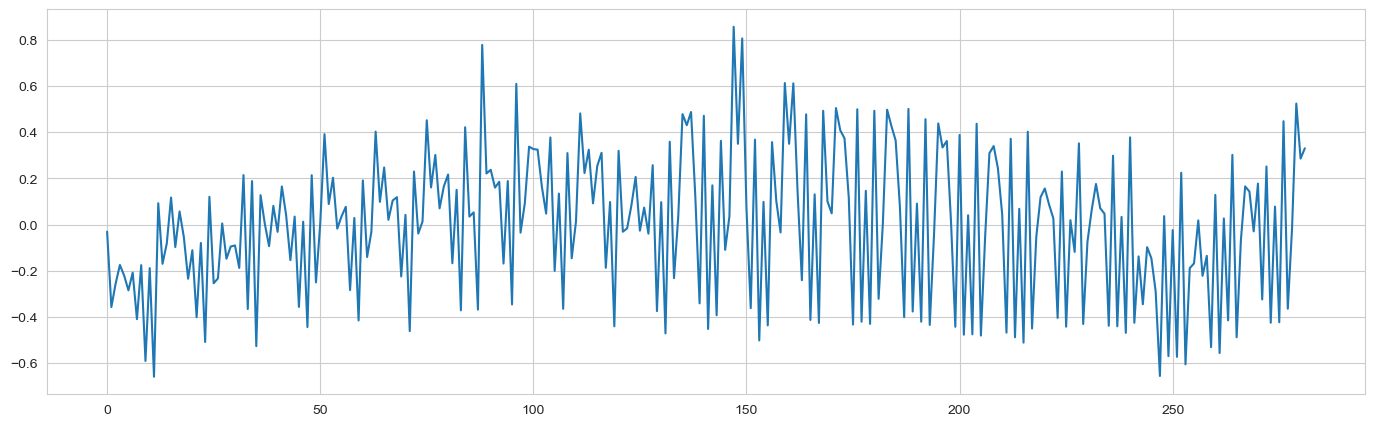

list

In [219]:
#Eliminando la tendencia de nuestra serie por los dos metodos
dian_sin_tend = [y[i]-trend[i] for i in range(0, len(dian_ts))]
dian_sin_tend_STL = [y[i]-trend_STL[i] for i in range(0, len(dian_ts))]
# plot sin tendencia por ajuste lineal
plt.plot(dian_sin_tend)
plt.show()
dian_detrend=pd.DataFrame(dian_sin_tend,index=dian_ts.index)
#print(dian_detrend)
type(dian_sin_tend_STL)

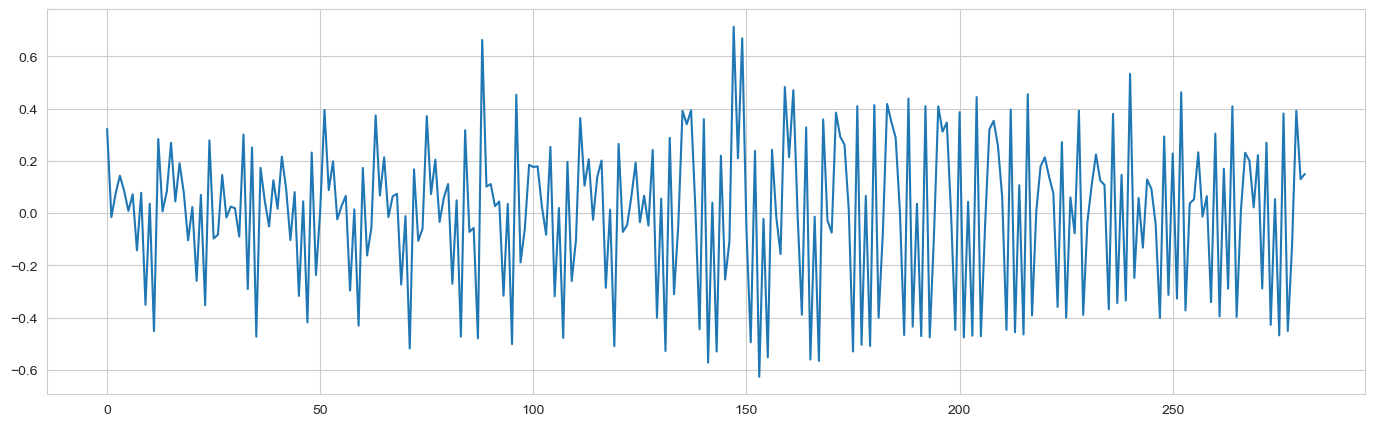

     Impuestos      fecha
0     0.322340 2000-01-01
1    -0.015343 2000-02-01
2     0.074891 2000-03-01
3     0.143338 2000-04-01
4     0.085165 2000-05-01
..         ...        ...
277  -0.451531 2023-02-01
278  -0.125276 2023-03-01
279   0.392097 2023-04-01
280   0.130139 2023-05-01
281   0.149983 2023-06-01

[282 rows x 2 columns]


In [220]:
# plot sin tendencia por STL
plt.plot(dian_sin_tend_STL)
plt.show()
data = {'Impuestos': dian_sin_tend_STL, 'fecha': dian_ts.index}
dian_detrend_STL_prueba=pd.DataFrame(data) ## Este es el que es bueno para usarlo en rede neuronales
dian_detrend_STL=pd.DataFrame(dian_sin_tend_STL,index=dian_ts.index)
print(dian_detrend_STL_prueba)


In [221]:
print(dian_ts.index)

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01'],
              dtype='datetime64[ns]', name='fecha', length=282, freq='MS')


## Estimación y/o eliminación de la componente estacional.


Ahora procederemos a estimar el ciclo estacional que se observa en esta serie de tiempo, es importante resaltar que con ayuda de los graficos exploratorios y el periodograma se observo que el periodo de la componente estacional es $s=12$, por lo tanto utilizaremos en primer lugar componentes de fourier, esto teniendo en cuenta que se aprecia que la componente estacional sigue un comportamiento deterministico y posiblemente sinosoidal.
Teniendo lo anterior en cuenta el modelo viene dado por:
$$\begin{align*}
x_t&=  ∑_{i=1}^k a_icos(k𝜔t)+b_isen(k𝜔t) + w_t \\
\end{align*}$$
Donde $k$ corresponderá al orden de la expansión en series de Fourier y los coeficientes $a_i$ y $b_i$ con $i=1,...,k$ serán estimados a través del método de mínimos cuadrados. El cálculo de esta componente se muestra a continuación considerando un orden $k=3$. 

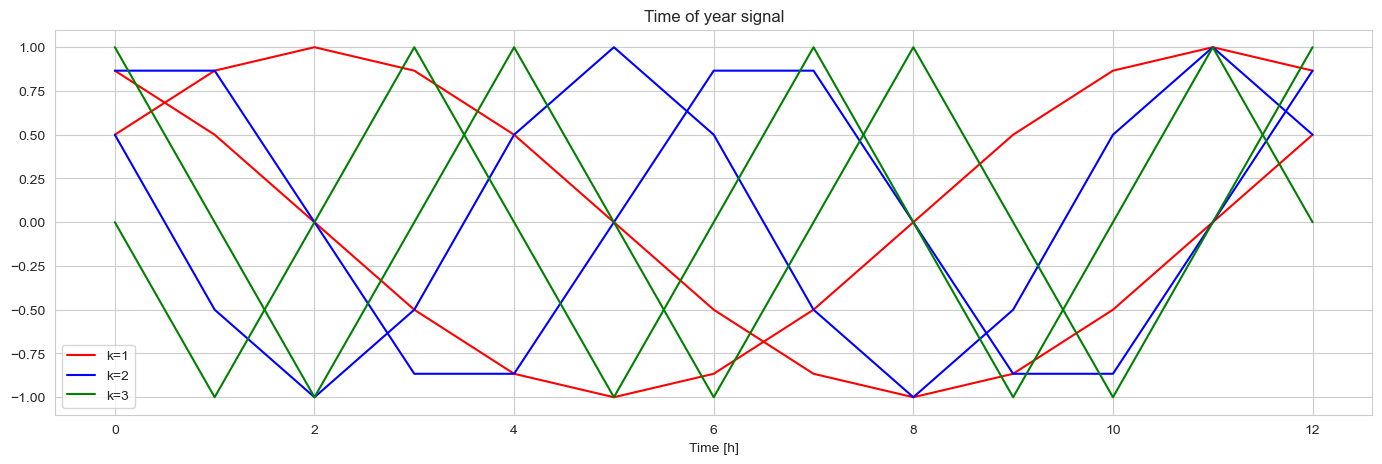

In [222]:
year = 1/(1/12)
dian2 = pd.DataFrame(dian_sin_tend_STL)## Aqui solo tengo que colocar la serie sin tendencia por el metodo que se elija.
#Fourier n=1 2pi*1
dian2['Year sin'] = np.sin(np.arange(1,283)*(2 * np.pi / year))
dian2['Year cos'] = np.cos(np.arange(1,283)*(2 * np.pi / year))

# Fourier n=2 2pi*2
dian2['Year sin2'] = np.sin(np.arange(1,283)*(4 * np.pi / year))
dian2['Year cos2'] = np.cos(np.arange(1,283)*(4 * np.pi / year))

# Fourier n=3 2pi*3
dian2['Year sin3'] = np.sin(np.arange(1,283)*(6 * np.pi / year))
dian2['Year cos3'] = np.cos(np.arange(1,283)*(6 * np.pi / year))

plt.plot(np.array(dian2['Year sin'])[:13], color="red", label="k=1")
plt.plot(np.array(dian2['Year cos'])[:13], color="red")

plt.plot(np.array(dian2['Year sin2'])[:13], color="blue", label="k=2")
plt.plot(np.array(dian2['Year cos2'])[:13], color="blue")

plt.plot(np.array(dian2['Year sin3'])[:13], color="green", label="k=3")
plt.plot(np.array(dian2['Year cos3'])[:13], color="green")

plt.xlabel('Impuestos')
plt.title('')
plt.legend()

In [230]:
x0=np.column_stack((dian2['Year cos'],dian2['Year sin']))
x1=np.column_stack((dian2['Year cos'],dian2['Year sin'],dian2['Year cos2'],dian2['Year sin2']))
X=np.column_stack((dian2['Year cos'],dian2['Year sin'],dian2['Year cos2'],dian2['Year sin2'],dian2['Year cos3'],dian2['Year sin3']))
linmodel_ciclo = sm.OLS(dian_sin_tend_STL, X)
linmodel_ciclo0 = sm.OLS(dian_sin_tend_STL, x0)
linmodel_ciclo1 = sm.OLS(dian_sin_tend_STL, x1)
results_ciclo = linmodel_ciclo.fit()
results_ciclo0 = linmodel_ciclo0.fit()
results_ciclo1 = linmodel_ciclo1.fit()
print(results_ciclo.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.246
Model:                            OLS   Adj. R-squared (uncentered):              0.229
Method:                 Least Squares   F-statistic:                              14.99
Date:                Tue, 17 Oct 2023   Prob (F-statistic):                    7.58e-15
Time:                        21:39:33   Log-Likelihood:                         -8.2875
No. Observations:                 282   AIC:                                      28.57
Df Residuals:                     276   BIC:                                      50.43
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

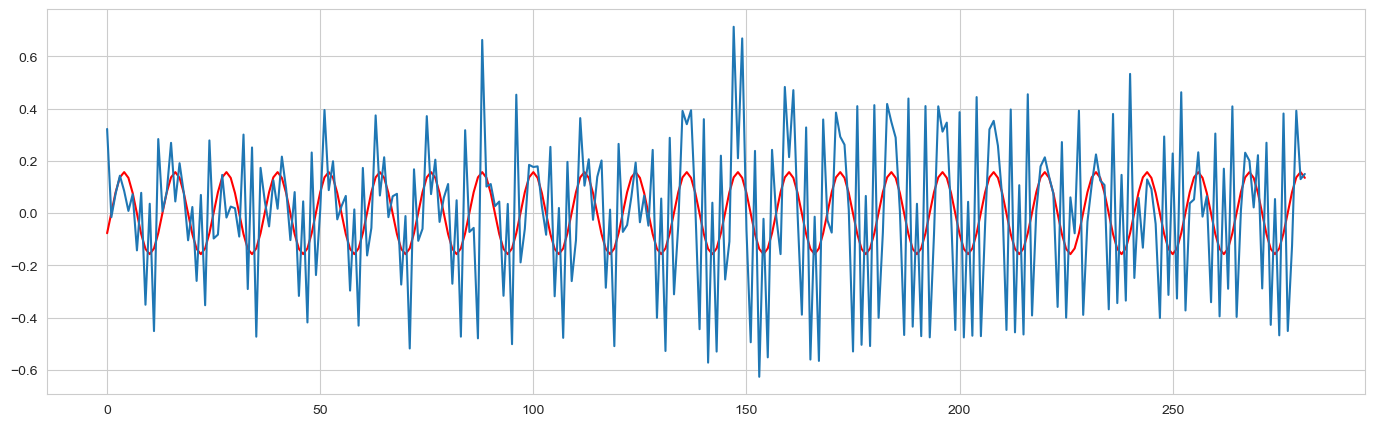

In [242]:
##Ajuste de la tendencia utilizando k=1
plt.plot(dian2["predict estacion0"], color="red")
plt.plot(dian_sin_tend_STL)

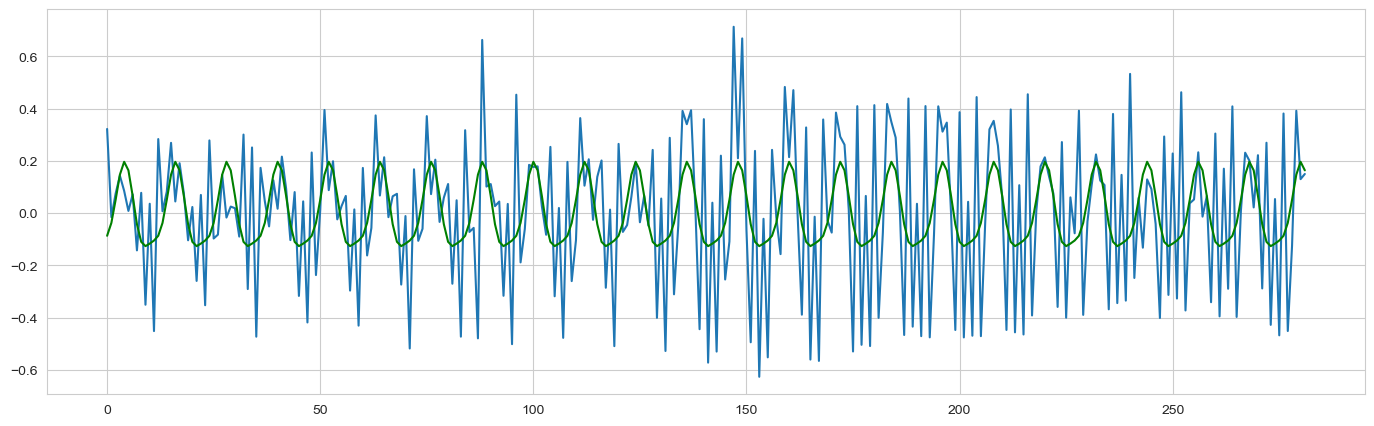

In [243]:
##Ajuste de la tendencia utilizando k=2
plt.plot(dian_sin_tend_STL)
plt.plot(dian2["predict estacion1"], color="green")

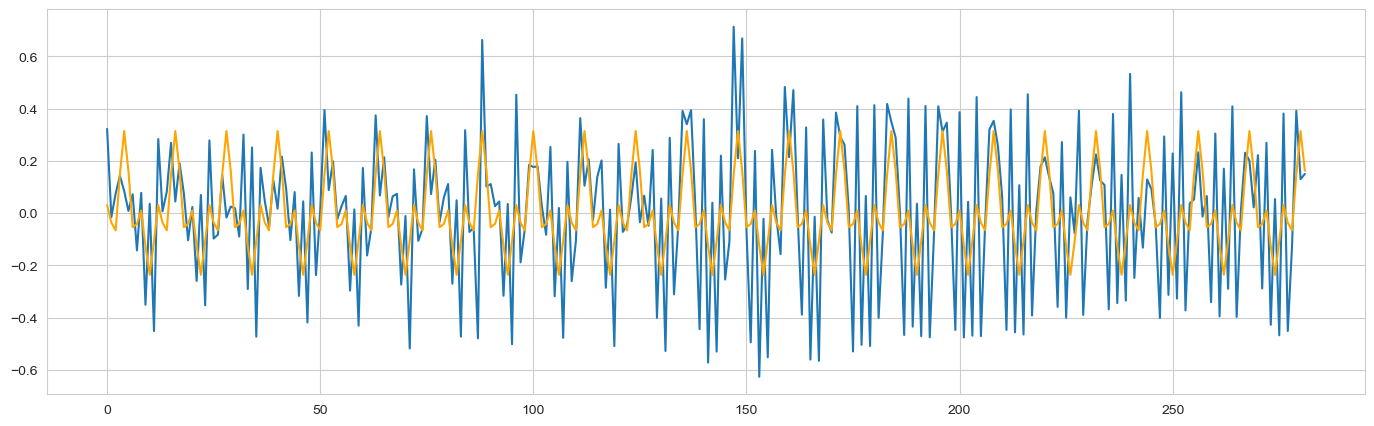

In [238]:
ypred = results_ciclo.predict(X)
ypred0 = results_ciclo0.predict(x0)
ypred1 = results_ciclo1.predict(x1)
dian2["predict estacion"] = ypred
dian2["predict estacion0"] = ypred0
dian2["predict estacion1"] = ypred1
plt.plot(dian_sin_tend_STL) ## Serie sin tendencia y con varianza estable en azul.
plt.plot(dian2["predict estacion"], color="orange")## EStimación de la componente estacional via componentes de fourier en color verde
#plt.plot(dian2["predict estacion0"], color="green")
#plt.plot(dian2["predict estacion1"], color="aliceblue")
plt.show()

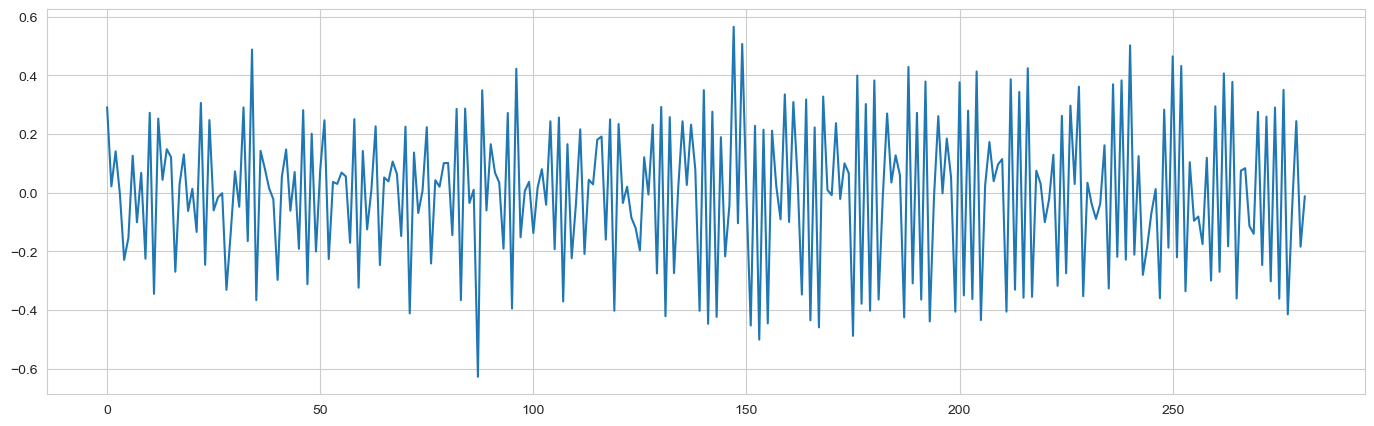

In [225]:
# Serie sin tendencia ni estacionalidad (STL) utilizando k=3
dian_sin_tend_sin_esta=dian_sin_tend_STL-ypred
plt.plot(dian_sin_tend_sin_esta)

## Árboles de decisión.


### Árboles de decisión con los datos quitando la tendencia.

 Para realizar el modelamiento de los arboles de decisión para esta serie de tiempo, vamos a proceder a realizar el ajuste del modelo utilizando los datos sin tendencia, posteriormente realizaremos la suma de dichas estimaciones para volver a los datos reales, Para la realización del modelamiento se van a utilizar 12 rezagos teniendo en cuenta lo obtenido en la parte descriptiva.

In [18]:
#Creación de variables rezagadas.
from pandas import DataFrame
dian3=pd.DataFrame(dian_sin_tend_STL)
# reframe as supervised learning
# lag observation (t-1) is the input variable and t is the output variable.
df1 = DataFrame()
print(df1)

for i in range(12,0,-1):# Colocar retardo de tamaño 12 
    df1[['t-'+str(i)]] = dian_detrend_STL.shift(i)
    
print(df1)

Empty DataFrame
Columns: []
Index: []
                t-12      t-11      t-10       t-9       t-8       t-7  \
fecha                                                                    
2000-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-03-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-05-01       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-02-01 -0.397591  0.008937  0.231389  0.200732  0.021884  0.221858   
2023-03-01  0.008937  0.231389  0.200732  0.021884  0.221858 -0.288416   
2023-04-01  0.231389  0.200732  0.021884  0.221858 -0.288416  0.269583   
2023-05-01  0.200732  0.021884  0.221858 -0.288416  0.269583 -0.427899   
2023-06-01  0.021884  0.221858 -0.288416  0.269583 -0.427899  0.053901   


In [19]:
df1['t'] = dian_detrend_STL.values
print(df1.head(13))

               t-12      t-11      t-10       t-9       t-8       t-7  \
fecha                                                                   
2000-01-01      NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-01      NaN       NaN       NaN       NaN       NaN       NaN   
2000-03-01      NaN       NaN       NaN       NaN       NaN       NaN   
2000-04-01      NaN       NaN       NaN       NaN       NaN       NaN   
2000-05-01      NaN       NaN       NaN       NaN       NaN       NaN   
2000-06-01      NaN       NaN       NaN       NaN       NaN       NaN   
2000-07-01      NaN       NaN       NaN       NaN       NaN       NaN   
2000-08-01      NaN       NaN       NaN       NaN       NaN  0.322340   
2000-09-01      NaN       NaN       NaN       NaN  0.322340 -0.015343   
2000-10-01      NaN       NaN       NaN  0.322340 -0.015343  0.074891   
2000-11-01      NaN       NaN  0.322340 -0.015343  0.074891  0.143338   
2000-12-01      NaN  0.322340 -0.015343  0.074891  

In [20]:
df1_dian = df1[12:]
print(df1_dian)
df1_dian.size

                t-12      t-11      t-10       t-9       t-8       t-7  \
fecha                                                                    
2001-01-01  0.322340 -0.015343  0.074891  0.143338  0.085165  0.008473   
2001-02-01 -0.015343  0.074891  0.143338  0.085165  0.008473  0.072029   
2001-03-01  0.074891  0.143338  0.085165  0.008473  0.072029 -0.142657   
2001-04-01  0.143338  0.085165  0.008473  0.072029 -0.142657  0.077735   
2001-05-01  0.085165  0.008473  0.072029 -0.142657  0.077735 -0.350828   
...              ...       ...       ...       ...       ...       ...   
2023-02-01 -0.397591  0.008937  0.231389  0.200732  0.021884  0.221858   
2023-03-01  0.008937  0.231389  0.200732  0.021884  0.221858 -0.288416   
2023-04-01  0.231389  0.200732  0.021884  0.221858 -0.288416  0.269583   
2023-05-01  0.200732  0.021884  0.221858 -0.288416  0.269583 -0.427899   
2023-06-01  0.021884  0.221858 -0.288416  0.269583 -0.427899  0.053901   

                 t-6       t-5       

3510

In [21]:
diansplit = df1_dian.values
# split into lagged variables and original time series
X1= diansplit[:, 0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y1 =diansplit[:,-1]  # slice all rows and last column, essentially separating out 't' column
print(X1)
print(y1)

[[ 0.32233957 -0.0153429   0.07489078 ... -0.35082807  0.03595827
  -0.45175963]
 [-0.0153429   0.07489078  0.14333836 ...  0.03595827 -0.45175963
   0.28367275]
 [ 0.07489078  0.14333836  0.08516487 ... -0.45175963  0.28367275
   0.00705416]
 ...
 [ 0.23138899  0.20073167  0.02188443 ...  0.38152086 -0.4515309
  -0.12527605]
 [ 0.20073167  0.02188443  0.22185841 ... -0.4515309  -0.12527605
   0.39209728]
 [ 0.02188443  0.22185841 -0.28841579 ... -0.12527605  0.39209728
   0.13013877]]
[ 0.28367275  0.00705416  0.08205201  0.26919699  0.04476042  0.19117181
  0.07659774 -0.10400002  0.02347435 -0.25963527  0.06963481 -0.35276526
  0.27847159 -0.09720624 -0.08232876  0.14632377 -0.01694773  0.02502207
  0.01871391 -0.08978421  0.30081913 -0.29073556  0.25148633 -0.47319794
  0.17346203  0.04566886 -0.05078701  0.12569194  0.01685146  0.21637538
  0.09343568 -0.10330965  0.0805805  -0.31710078  0.04496536 -0.41871072
  0.23217719 -0.23714447  0.01178134  0.39502413  0.08813366  0.1986464

In [22]:
# Target Train-Validation-Test split(70-10-20)
from pandas import read_csv

Y1 = y1
traintarget_size = int(len(Y1) * 0.70) 
valtarget_size = int(len(Y1) * 0.10)+1# Set split
testtarget_size = int(len(Y1) * 0.20)# Set split
train_target, val_target,test_target = Y1[0:traintarget_size],Y1[(traintarget_size):(traintarget_size+valtarget_size)] ,Y1[(traintarget_size+valtarget_size):len(Y1)]

print('Observaciones respuesta: %d' % (len(Y1)))
print('Tamaño respuestas de entrenamiento: %d' % (len(train_target)))
print('Tamaño respuestas de validación: %d' % (len(val_target)))
print('Tamaño respuestas de prueba: %d' % (len(test_target)))

trainfeature_size = int(len(X1) * 0.70)
valfeature_size = int(len(X1) * 0.10)+1# Set split
testfeature_size = int(len(X1) * 0.20)# Set split
train_feature, val_feature,test_feature = X1[0:traintarget_size],X1[(traintarget_size):(traintarget_size+valtarget_size)] ,X1[(traintarget_size+valtarget_size):len(Y1)]

print('Observaciones covariables: %d' % (len(X1)))
print('Tamaño covariables de entrenamiento: %d' % (len(train_feature)))
print('Tamaño covariables de validación: %d' % (len(val_feature)))
print('Tamaño covariables de prueba: %d' % (len(test_feature)))


Observaciones respuesta: 270
Tamaño respuestas de entrenamiento: 189
Tamaño respuestas de validación: 28
Tamaño respuestas de prueba: 53
Observaciones covariables: 270
Tamaño covariables de entrenamiento: 189
Tamaño covariables de validación: 28
Tamaño covariables de prueba: 53


In [23]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_dian = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_dian.fit(train_feature, train_target)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_dian.score(train_feature, train_target))
print("Coeficiente R2 sobre el conjunto de Validación:",decision_tree_dian.score(val_feature,val_target))  # predictions are horrible if negative value, no relationship if 0
print("el RECM sobre validación es:",(((decision_tree_dian.predict(val_feature)-val_target)**2).mean()) )


Coeficiente R2 sobre el conjunto de entrenamiento: 1.0
Coeficiente R2 sobre el conjunto de Validación: 0.8481191733795871
el RECM sobre validación es: 0.016001233606183687


In [24]:
# Find the best Max Depth

# Loop through a few different max depths and check the performance
# Try different max depths. We want to optimize our ML models to make the best predictions possible.
# For regular decision trees, max_depth, which is a hyperparameter, limits the number of splits in a tree.
# You can find the best value of max_depth based on the R-squared score of the model on the test set.


for d in [2, 3, 4, 5,6,7,8,9,10,11]:
    # Create the tree and fit it
    decision_tree_dian = DecisionTreeRegressor(max_depth=d)
    decision_tree_dian.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('Produnidad=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_dian.score(train_feature, train_target))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_dian.score(val_feature, val_target))  # You want the test score to be positive and high
    print("el RECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_dian.predict(val_feature),val_target, squared=False),"\n")

Produnidad= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7176769383461999
Coeficiente R2 sobre el conjunto de validación: 0.843424906429449
el RECM sobre el conjunto de validación es: 0.12843594831337452 

Produnidad= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.795456595745584
Coeficiente R2 sobre el conjunto de validación: 0.8977736085298402
el RECM sobre el conjunto de validación es: 0.10377835254789944 

Produnidad= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.8698500803688292
Coeficiente R2 sobre el conjunto de validación: 0.8653952623943499
el RECM sobre el conjunto de validación es: 0.11908455267375379 

Produnidad= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9168999958109662
Coeficiente R2 sobre el conjunto de validación: 0.8746168135523384
el RECM sobre el conjunto de validación es: 0.11493304371895757 

Produnidad= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.951353554461148
Coeficiente R2 sobre el conjunto de validación: 0.8

Teniendo en cuenta la explroación anterior, es posible observar que aquella que hace maximo el valor $R^{2}$ y minimiza el error cuadratico medio (RECM) es la profundidad **3** por lo  tanto se elige esta profundidad como hiper-parametro para continuar con la construcción del modelo.

## Juntando entrenamiento y validación.


In [25]:
print(type(train_feature))
print(type(val_feature))

#######

print(type(train_target))
print(type(val_target))

####
print(train_feature.shape)
print(val_feature.shape)

#####

####
print(train_target.shape)
print(val_target.shape)

###Concatenate Validation and test

train_val_feature=np.concatenate((train_feature,val_feature),axis=0)
train_val_target=np.concatenate((train_target,val_target),axis=0)
print(train_val_feature.shape)
print(train_val_target.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(189, 12)
(28, 12)
(189,)
(28,)
(217, 12)
(217,)


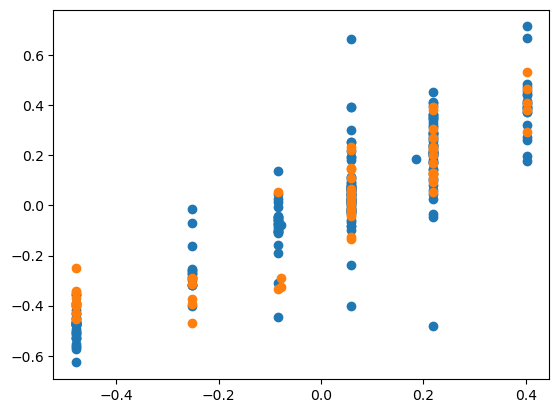

Raíz de la Pérdida cuadrática Entrenamiento: 0.12364716095776558
Raíz de la Pérdida cuadrática Prueba: 0.11939998731886053


In [26]:
# Prediccion utilizando los datos sumados de entrenamiento y validación y con la profundidad 3.

from matplotlib import pyplot as plt

# Usando la mejor maxima profundidad

decision_tree_dian = DecisionTreeRegressor(max_depth=3)  # fill in best max depth here
decision_tree_dian.fit(train_val_feature, train_val_target)

# Prediciendo valores para entrenamiento y prueba 
train_val_prediction = decision_tree_dian.predict(train_val_feature)
test_prediction = decision_tree_dian.predict(test_feature)

# Comparación de los valores predichos vs los reales 
plt.scatter(train_val_prediction, train_val_target, label='train')  # blue
plt.scatter(test_prediction, test_target, label='test')  # orange
plt.show()
print("Raíz de la Pérdida cuadrática Entrenamiento:",sklearn.metrics.mean_squared_error( train_val_prediction, train_val_target,squared=False))

print("Raíz de la Pérdida cuadrática Prueba:",sklearn.metrics.mean_squared_error(test_prediction, test_target,squared=False))

In [27]:
from sklearn import tree

listacaract=list(df1_dian.columns.values)
respuesta=["t"]
text_representation = tree.export_text(decision_tree_dian)
print(text_representation)
print(respuesta)

|--- feature_0 <= -0.18
|   |--- feature_1 <= 0.45
|   |   |--- feature_0 <= -0.35
|   |   |   |--- value: [-0.48]
|   |   |--- feature_0 >  -0.35
|   |   |   |--- value: [-0.25]
|   |--- feature_1 >  0.45
|   |   |--- feature_11 <= 0.00
|   |   |   |--- value: [0.18]
|   |   |--- feature_11 >  0.00
|   |   |   |--- value: [-0.08]
|--- feature_0 >  -0.18
|   |--- feature_0 <= 0.12
|   |   |--- feature_0 <= -0.04
|   |   |   |--- value: [-0.08]
|   |   |--- feature_0 >  -0.04
|   |   |   |--- value: [0.06]
|   |--- feature_0 >  0.12
|   |   |--- feature_0 <= 0.37
|   |   |   |--- value: [0.22]
|   |   |--- feature_0 >  0.37
|   |   |   |--- value: [0.40]

['t']


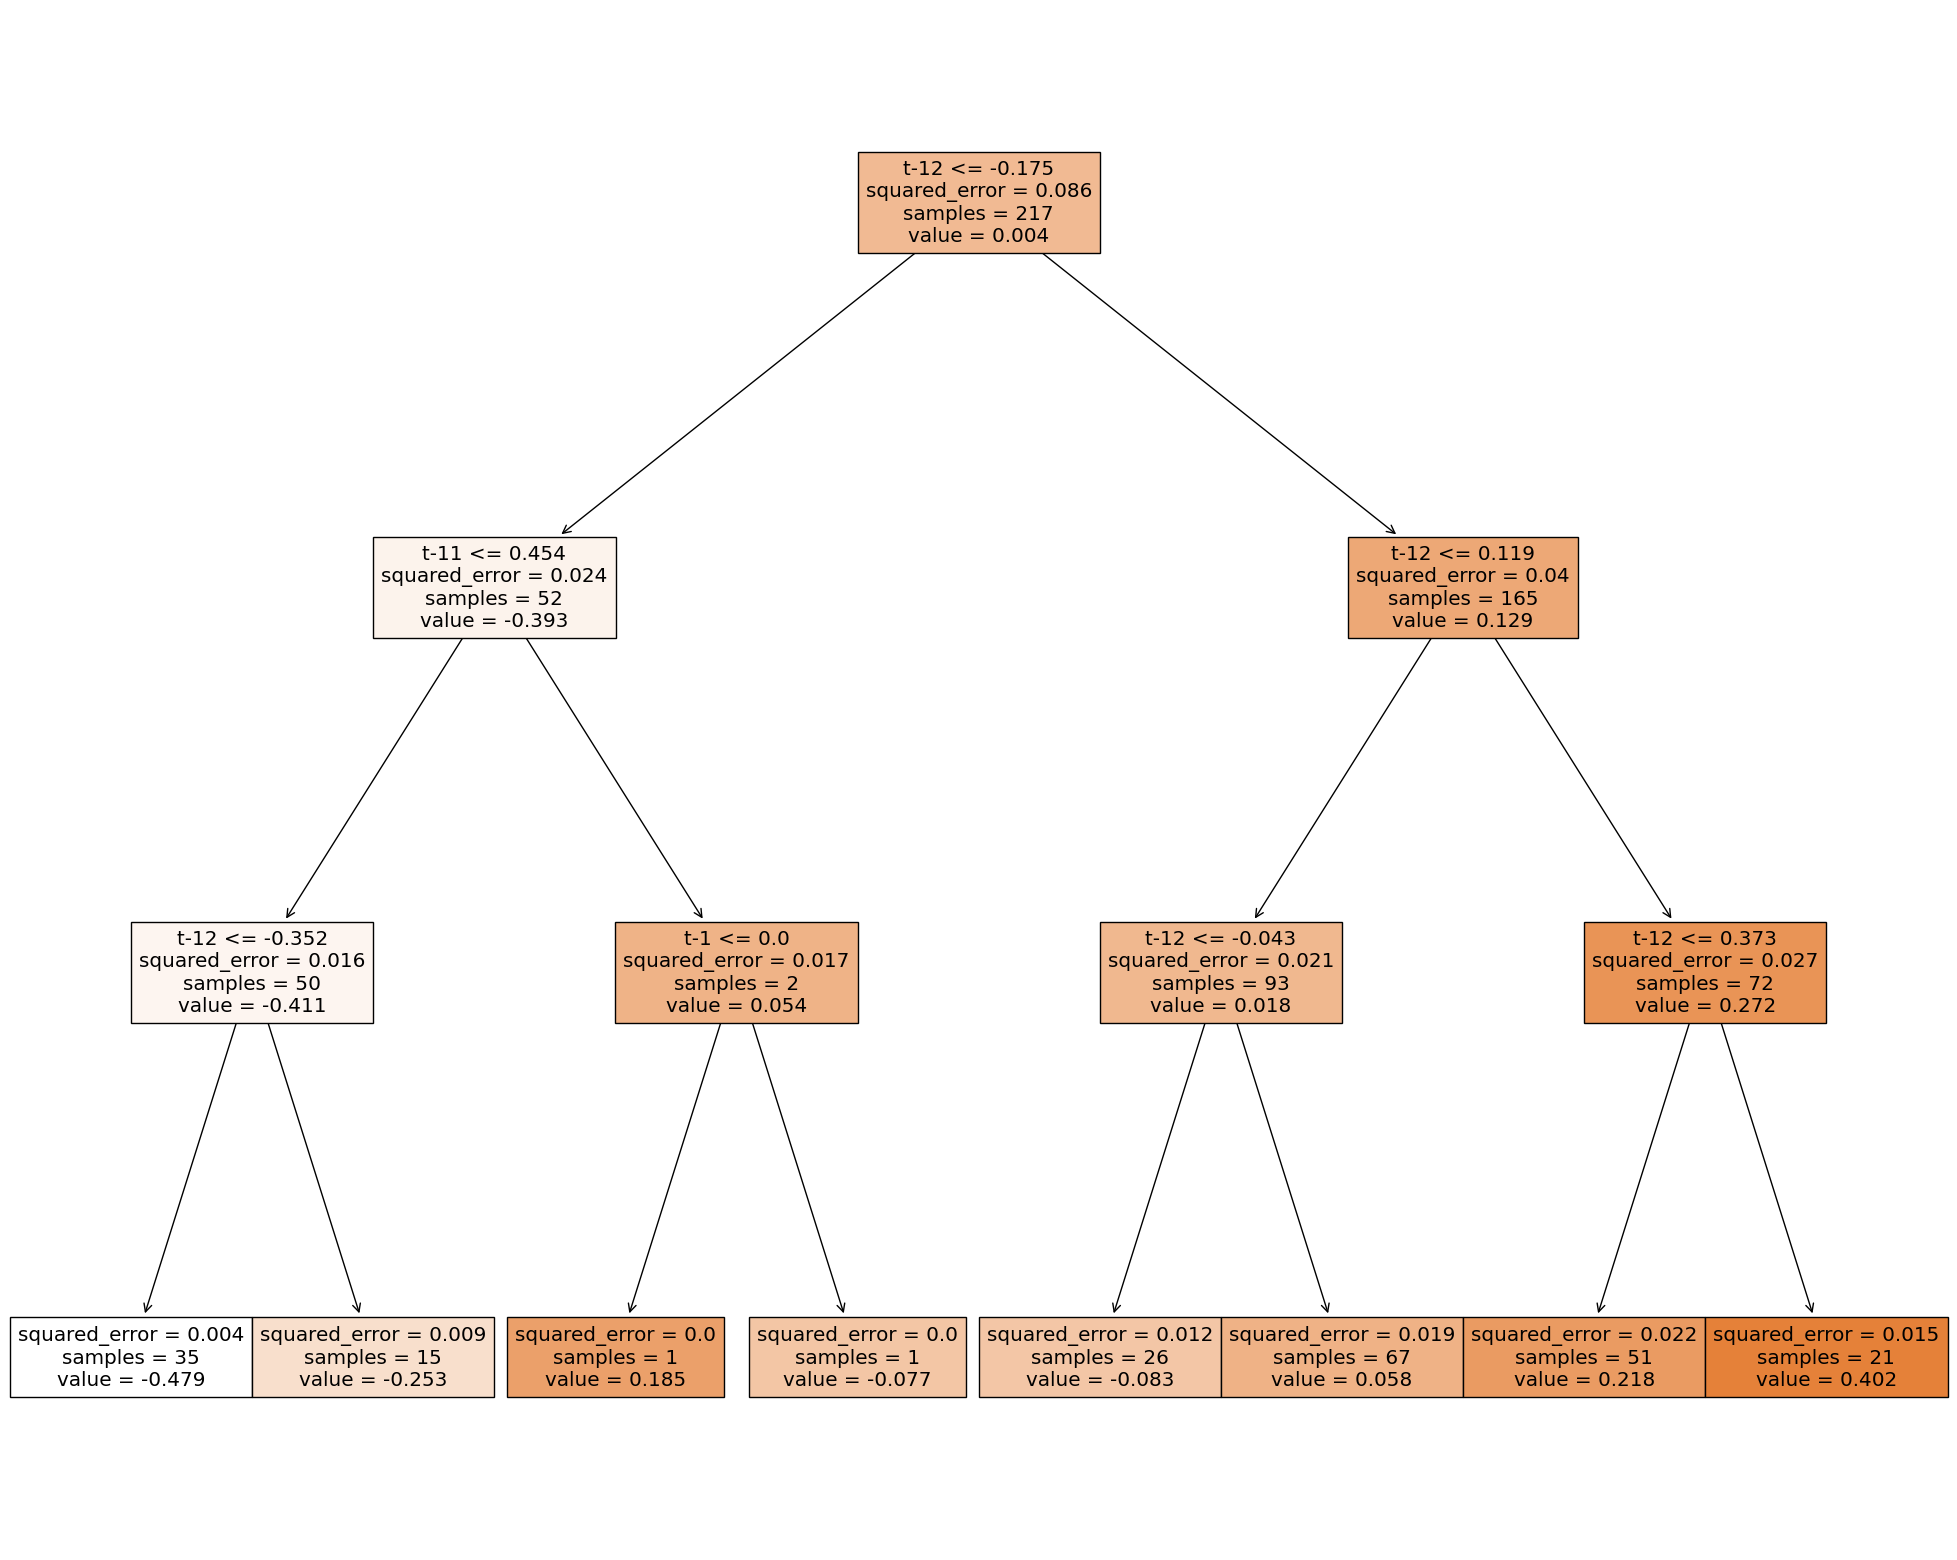

In [28]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_dian, 
                   feature_names=listacaract,  
                   class_names=respuesta,
                   filled=True)

Ahora se van a observar los tamaños de los conjuntos usados para entrenamiento y pureba con el fin de realizar los graficos de la serie real con las predicciones.

In [29]:
print(train_val_prediction.size)
print(train_val_target.size)

print(test_prediction.size)
print(test_target.size)

217
217
53
53


In [30]:
indicetrian_val_test=df1_dian.index
print(indicetrian_val_test.size)  ###Tamaño del índice
indicetrain_val=indicetrian_val_test[0:217]
indicetest=indicetrian_val_test[217:270]

270


In [31]:
print(indicetrain_val.size)
print(indicetest.size)

217
53


In [32]:
targetjoint=np.concatenate((train_val_target,test_target))
predictionjoint=np.concatenate((train_val_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

270
270


In [33]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_val_test)
ObsvsPred.head(10)

,observado,Predicción
fecha,,
2001-01-01,0.283673,0.218191
2001-02-01,0.007054,0.057622
2001-03-01,0.082052,0.057622
2001-04-01,0.269197,0.218191
2001-05-01,0.044760,0.057622
2001-06-01,0.191172,0.057622
2001-07-01,0.076598,0.057622
2001-08-01,-0.104000,-0.083217
2001-09-01,0.023474,0.057622


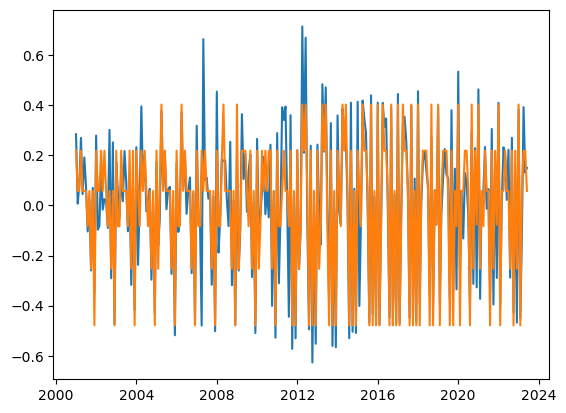

In [34]:
plt.plot(ObsvsPred) ## Valores predichos vs los valores reales de la serie sin tendencia.

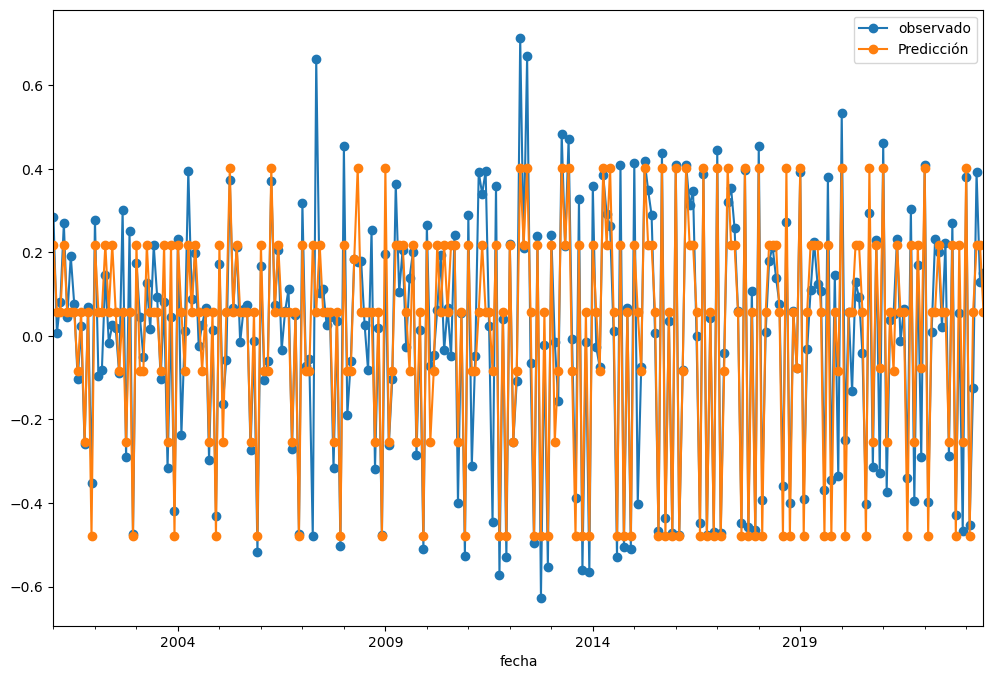

In [35]:
ax = ObsvsPred.plot( marker="o", figsize=(12,8))
#ax.axvline(x=indicetrian_val_test[150].date(),color='red') ## Preguntar que hace este valor 150

## Sumando nuevamente la tendencia.

Teniendo en cuenta que anteriormente se eliminó la tendencia, es necesario volver a sumar dicha tendencia estimada a las predicciones obtenidas por el arbol de decisión esto se hace a continuacioón.


In [36]:
from scipy.special import boxcox, inv_boxcox

test_p_reg = trend[229:283] + test_prediction
test_target_reg = trend[229:283] + test_target

test_p_orig = inv_boxcox(test_p_reg, 0)
test_target_orig = inv_boxcox(test_target_reg, 0)

Resid_arb=test_p_orig - test_target_orig
print("ECM en el conjunto de prueba: ", np.sqrt(sum(Resid_arb**2)))

pred = np.concatenate((train_val_prediction, test_prediction))
pred_reg = trend_STL[12:283] + pred
pred_orig = inv_boxcox(pred_reg, 0)

target = np.concatenate((train_val_target, test_target))
target_reg = trend_STL[12:283] + target
target_orig = inv_boxcox(target_reg, 0)

Plot_predic = {'Original' : target_orig,'Prediccion' : pred_orig}
Todo=pd.DataFrame(data=Plot_predic, index=df1_dian.index)
print(Todo)

ECM en el conjunto de prueba:  11804930.888755059
                Original    Prediccion
fecha                                 
2001-01-01  1.893430e+06  1.773416e+06
2001-02-01  1.469073e+06  1.545271e+06
2001-03-01  1.617877e+06  1.578831e+06
2001-04-01  1.990345e+06  1.891370e+06
2001-05-01  1.620028e+06  1.640999e+06
...                  ...           ...
2023-02-01  1.128225e+07  1.098033e+07
2023-03-01  1.611574e+07  1.935005e+07
2023-04-01  2.789091e+07  2.343884e+07
2023-05-01  2.216499e+07  2.420517e+07
2023-06-01  2.337360e+07  2.131150e+07

[270 rows x 2 columns]


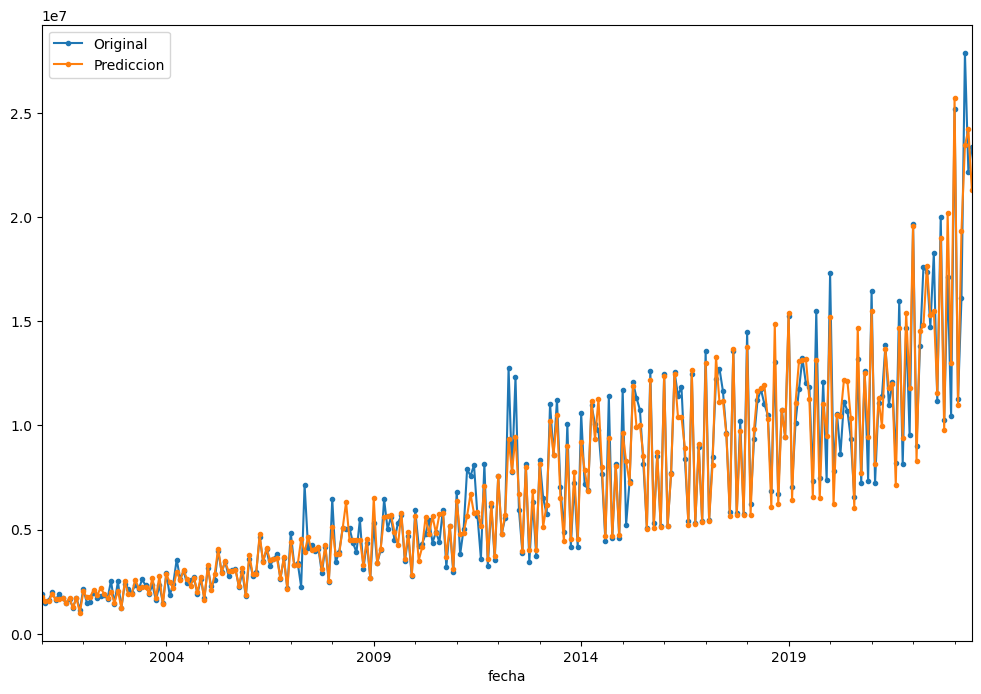

In [37]:
ax = Todo.plot( marker=".", figsize=(12,8))
#ax.axvline(x=dian_ts.index[129].date(),color='purple')
#ax.axvline(x=dian_ts.index[167].date(),color='purple')

Para este modelo se obtuvo un valor de **RECM** de  **$11804930.888755059$**.

## Modelo de redes neuronales.

Luego de realizar el análisis utilizando árboles de decisión vamos a proceder a realizar el análisis utilizando redes neuronales Multicapa y redes neuronales recurrentes, en primer lugar buscaremos los parametros que hacen óptimo el modelo de redes neuronales multicapa y se realizará el modelo de redes recurrentes utilizando para ambos modelos la serie original.

## Redes neuronales multicapa.

In [38]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.14.0
Pandas Version: 2.0.3
Numpy Version: 1.24.3
System Version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


## Cargando de nuevo los datos.

In [39]:
nombre_del_archivo = "dian_phyton.csv"
df = pd.read_csv(nombre_del_archivo,decimal=",")
dian = df.iloc[:, 1:]
dian["Impuestos"]=pd.to_numeric(dian["Impuestos"])
print(dian)

        Impuestos       fecha
0    1.512329e+06  2000-01-01
1    1.100415e+06  2000-02-01
2    1.228774e+06  2000-03-01
3    1.343029e+06  2000-04-01
4    1.293771e+06  2000-05-01
..            ...         ...
277  1.128225e+07  2023-02-01
278  1.611574e+07  2023-03-01
279  2.789091e+07  2023-04-01
280  2.216499e+07  2023-05-01
281  2.337360e+07  2023-06-01

[282 rows x 2 columns]


In [40]:
type(dian)
#type(dian_detrend_STL_prueba)

pandas.core.frame.DataFrame

In [41]:
##Datos bonitos con transformación box cox (logaritmo) y sin tendencia (STL).
print(dian_detrend_STL_prueba)


     Impuestos      fecha
0     0.322340 2000-01-01
1    -0.015343 2000-02-01
2     0.074891 2000-03-01
3     0.143338 2000-04-01
4     0.085165 2000-05-01
..         ...        ...
277  -0.451531 2023-02-01
278  -0.125276 2023-03-01
279   0.392097 2023-04-01
280   0.130139 2023-05-01
281   0.149983 2023-06-01

[282 rows x 2 columns]


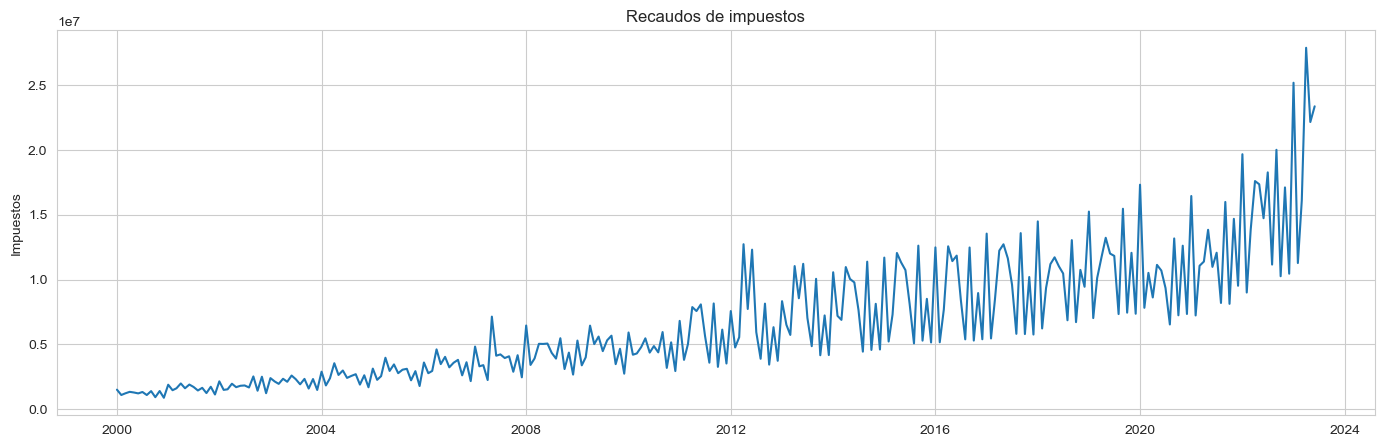

In [42]:
## Datos originales, sin transformar por box cox y sin eliminar la tendencia.
dian['fecha']=pd.to_datetime(dian['fecha']) # pasar a formato fecha
Valores_dian=dian.set_index('fecha') # nuevo dataframe indexado por la fecha
Valores_dian['Impuestos'] = pd.to_numeric(Valores_dian['Impuestos'], errors='coerce')
dian_ts=Valores_dian['Impuestos'] # vector con los valores de la serie

plt.plot(dian_ts)
plt.title('Recaudos de impuestos')
plt.ylabel('Impuestos')
plt.show()

In [43]:
Valores_dian.head()

,Impuestos
fecha,
2000-01-01,1.512329e+06
2000-02-01,1.100415e+06
2000-03-01,1.228774e+06
2000-04-01,1.343029e+06
2000-05-01,1.293771e+06


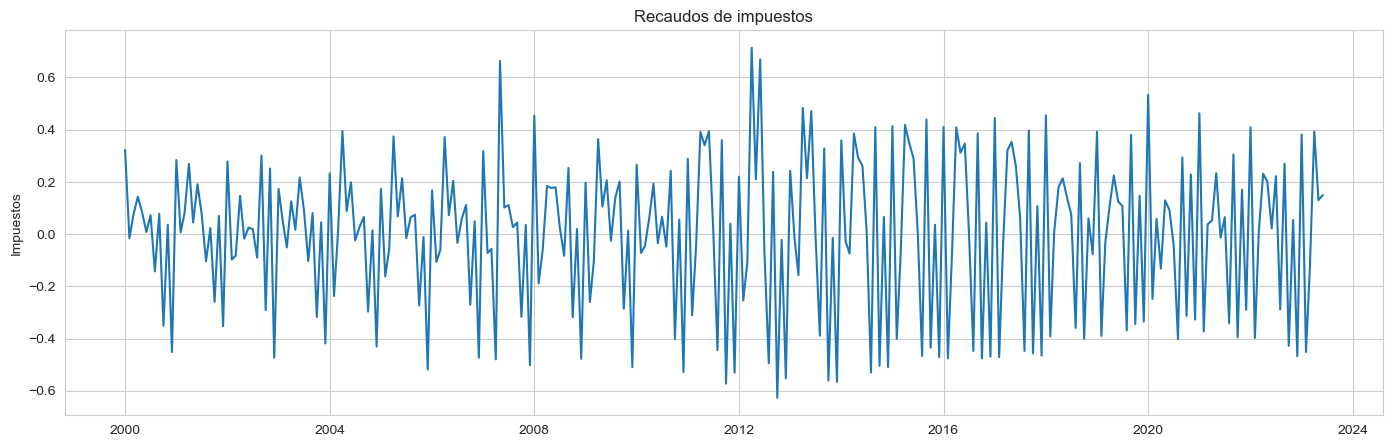

In [44]:
## Datos transformados por box cox y sin tendencia aplicando STL.
dian_detrend_STL_prueba['fecha']=pd.to_datetime(dian_detrend_STL_prueba['fecha']) # pasar a formato fecha
Valores_dian_STL=dian_detrend_STL_prueba.set_index('fecha') # nuevo dataframe indexado por la fecha
Valores_dian_STL['Impuestos'] = pd.to_numeric(Valores_dian_STL['Impuestos'], errors='coerce')
dian_ts_2=Valores_dian_STL['Impuestos'] # vector con los valores de la serie

plt.plot(dian_ts_2)
plt.title('Recaudos de impuestos')
plt.ylabel('Impuestos')
plt.show()

In [45]:
Valores_dian_STL.head()

,Impuestos
fecha,
2000-01-01,0.322340
2000-02-01,-0.015343
2000-03-01,0.074891
2000-04-01,0.143338
2000-05-01,0.085165


In [46]:
features_considered2 = ['Impuestos']

In [47]:
features2 = Valores_dian[features_considered2]#Aqui lo estoy haciendo con los datos transformados y sin tendencia, pero lo puedo cambiar por valores_dian si quiero usar los datos originales
features2.index = Valores_dian_STL.index#Mismo cambio aqui
features2.head()

,Impuestos
fecha,
2000-01-01,1.512329e+06
2000-02-01,1.100415e+06
2000-03-01,1.228774e+06
2000-04-01,1.343029e+06
2000-05-01,1.293771e+06


In [48]:
#features.plot(subplots=True) # Este codigo se tiene para realizar el grafico para la series original

array([<Axes: xlabel='fecha'>], dtype=object)

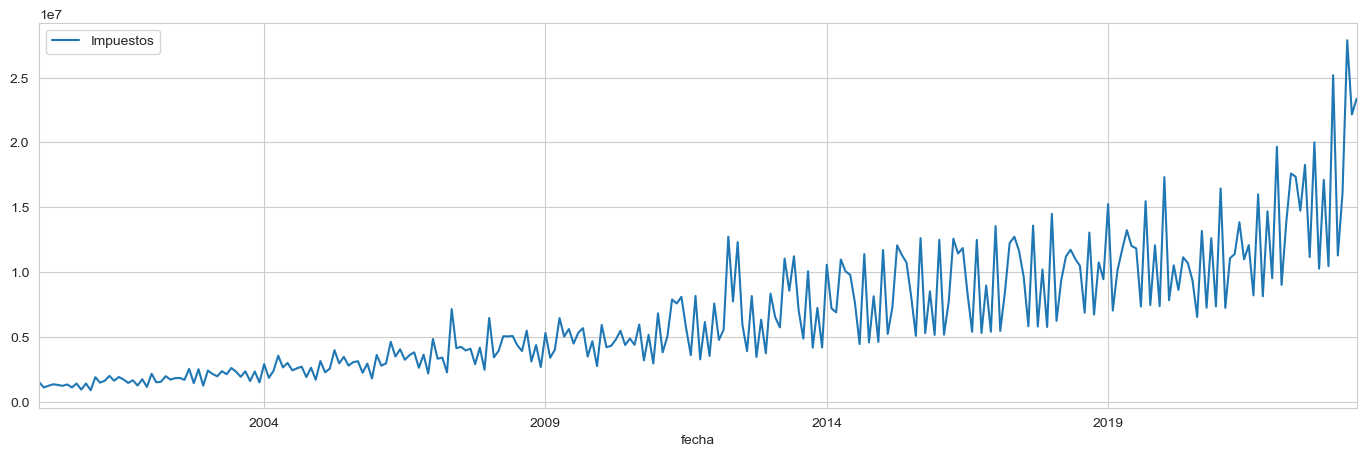

In [49]:
features2.plot(subplots=True)

In [50]:
### Separación de los datos en entrenamiento, validación y prueba teniendo en cuenta la proporción 70%, 20% y 10%
column_indices = {name: i for i, name in enumerate(features2.columns)}##Cambie el features por features2

n = len(features2)
train_df = features2[0:int(n*0.7)]
val_df = features2[int(n*0.7):int(n*0.8)]
test_df = features2[int(n*0.8):]

num_features = features2.shape[1]

In [51]:
## Normalización de los datos.
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [52]:
train_df

,Impuestos
fecha,
2000-01-01,-1.028665
2000-02-01,-1.170182
2000-03-01,-1.126083
2000-04-01,-1.086829
2000-05-01,-1.103753
...,...
2016-01-01,2.742318
2016-02-01,0.227443
2016-03-01,1.094684


In [53]:
print("longitud dataframe entrenamiento:",train_df.shape)
print("longitud dataframe validación:",val_df.shape)
print("longitud dataframe prueba:",test_df.shape)

longitud dataframe entrenamiento: (197, 1)
longitud dataframe validación: (56, 1)
longitud dataframe prueba: (29, 1)


In [54]:
df_std = (features2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
df_std

,Column,Normalized
0,Impuestos,-1.028665
1,Impuestos,-1.170182
2,Impuestos,-1.126083
3,Impuestos,-1.086829
4,Impuestos,-1.103753
...,...,...
277,Impuestos,2.327900
278,Impuestos,3.988501
279,Impuestos,8.033991
280,Impuestos,6.066787


## Función WindowGenerator.

In [55]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Split

In [56]:
def split_window(self, features2):### Aqui cambie features2 a features
  inputs = features2[:, self.input_slice, :]
  labels = features2[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## Objetos a TensorFlow

In [57]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=128,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [58]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Definir las gráficas.

In [59]:
def plot(self, model=None, plot_col='Impuestos', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Impuestos')

WindowGenerator.plot = plot

In [121]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [153]:
## Creación de la ventana que se va a utilizar en el modelamiento de las series mutlicapa y las series recurrentes
single_step_window = WindowGenerator(
    input_width=12, label_width=1, shift=1, ##Input_width me dice los retardos que quiero tener en cuenta por ende lo voy a cambiar por 12
    label_columns=['Impuestos'])# La variable a predecir es Impuestos
single_step_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12]
Label column name(s): ['Impuestos']

## Buscando los mejores hiperparametros (para el modelo multicapa).

In [62]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [154]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

In [155]:
for batch in single_step_window.train.take(1):
    inputs_train,targets_train = batch
    

print("Input shape:", inputs_train.numpy().shape)
print("Target shape:", targets_train.numpy().shape)

Input shape: (128, 12, 1)
Target shape: (128, 1, 1)


In [156]:
for batch in single_step_window.val.take(1):
    inputs_val,targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (44, 12, 1)
Target shape: (44, 1, 1)


In [157]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [158]:
input_dataset_train = single_step_window.train.map(lambda x,y: x)
target_dataset_train = single_step_window.train.map(lambda x,y: y)
input_dataset_train

<_MapDataset element_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None)>

In [159]:
input_dataset_val = single_step_window.val.map(lambda x,y: x)
target_dataset_val = single_step_window.val.map(lambda x,y: y)
print(input_dataset_val)
print(target_dataset_val)

<_MapDataset element_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [160]:
input_dataset_test = single_step_window.test.map(lambda x,y: x)
target_dataset_test = single_step_window.test.map(lambda x,y: y)
print(input_dataset_test)
print(target_dataset_test)

<_MapDataset element_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


## Definiendo el hipermodelo 

In [161]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

In [162]:
tf.random.set_seed(123)
tuner_RandomSearch_mlp = kt.BayesianOptimization( ## Aqui hice el cambio de BayesianOptimization por RandomSearch ya que esmás recomendable el bayesiano
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [163]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=0)

In [164]:
tf.random.set_seed(123)
tuner_RandomSearch_mlp.search_space_summary()
tuner_RandomSearch_mlp.search((single_step_window.train), epochs=10, validation_data=(single_step_window.val),callbacks=[stop_early])

Trial 3 Complete [00h 00m 04s]
val_loss: 1.7425121068954468

Best val_loss So Far: 1.7425121068954468
Total elapsed time: 00h 00m 07s


In [165]:
# Obteniendo los 2 mejores modelos.
models_mlp = tuner_RandomSearch_mlp.get_best_models(num_models=2)
best_model_mlp = models_mlp[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model_mlp.build(input_shape=(128, 12, 1))## Preguntar si en el espacio de enmedio va un 12 o va un 1 teniendo en cuenta que estoy tomando 12 retardos
best_model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (128, 12, 256)            512       
                                                                 
 dense_1 (Dense)             (128, 12, 512)            131584    
                                                                 
 dense_2 (Dense)             (128, 12, 128)            65664     
                                                                 
 dense_3 (Dense)             (128, 12, 32)             4128      
                                                                 
 dense_4 (Dense)             (128, 12, 1)              33        
                                                                 
Total params: 201921 (788.75 KB)
Trainable params: 201921 (788.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [166]:
tuner_RandomSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_units: 256
activation: relu
num_layers: 3
units_0: 512
dropout: False
lr: 0.0009758909113438307
units_1: 128
units_2: 32
Score: 1.7425121068954468

Trial 0 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 1
units_0: 480
dropout: True
lr: 0.002240400697178969
Score: 1.7551308870315552

Trial 1 summary
Hyperparameters:
num_units: 128
activation: tanh
num_layers: 2
units_0: 448
dropout: False
lr: 0.004187215793882192
units_1: 32
Score: 1.9171429872512817


In [167]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)## Unir entrenamiento y validación

In [168]:
train_plus_val

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [169]:
# Get the top 2 hyperparameters.
best_hps_mlp = tuner_RandomSearch_mlp.get_best_hyperparameters(5)  
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5)
model_mlp = build_model(best_hps_mlp[0])
# Fit with the entire dataset.
model_mlp.fit(train_plus_val, epochs=10,callbacks=[callback])

Epoch 1/10
3/3 [==============================] - 1s 22ms/step - loss: 1.4143 - mean_squared_error: 1.4143
Epoch 2/10
3/3 [==============================] - 0s 19ms/step - loss: 1.0584 - mean_squared_error: 1.0584
Epoch 3/10
3/3 [==============================] - 0s 25ms/step - loss: 0.9102 - mean_squared_error: 0.9102
Epoch 4/10
3/3 [==============================] - 0s 23ms/step - loss: 0.9577 - mean_squared_error: 0.9577
Epoch 5/10
3/3 [==============================] - 0s 24ms/step - loss: 0.9354 - mean_squared_error: 0.9354
Epoch 6/10
3/3 [==============================] - 0s 21ms/step - loss: 0.8551 - mean_squared_error: 0.8551
Epoch 7/10
3/3 [==============================] - 0s 23ms/step - loss: 0.8234 - mean_squared_error: 0.8234
Epoch 8/10
3/3 [==============================] - 0s 20ms/step - loss: 0.7982 - mean_squared_error: 0.7982
Epoch 9/10
3/3 [==============================] - 0s 20ms/step - loss: 0.7662 - mean_squared_error: 0.7662
Epoch 10/10
3/3 [====================

In [170]:
model_mlp.layers[0].get_weights()[0]

array([[ 7.32382387e-02,  3.25340517e-02,  6.03217743e-02,
         4.07737866e-02,  1.52655348e-01,  5.69263697e-02,
        -2.48422418e-02, -8.44659880e-02,  4.69316449e-03,
         7.00326711e-02,  3.45347449e-02, -6.17571995e-02,
        -1.29285472e-04,  1.11850854e-02,  1.13174714e-01,
        -1.48093626e-01,  1.41996332e-02, -1.23862959e-01,
         8.26189667e-02, -1.14491805e-01, -1.39236733e-01,
         7.12765157e-02,  1.54703911e-02,  7.59164542e-02,
         4.09516282e-02, -5.99990971e-02, -1.13040231e-01,
        -1.17493920e-01, -1.35668382e-01,  1.19784772e-01,
         9.66381803e-02, -1.09106123e-01, -1.23966902e-01,
        -1.10651394e-02,  1.34249762e-01, -1.63806975e-02,
        -1.18744537e-01, -5.66276796e-02, -1.06631368e-01,
         1.38644859e-01, -7.24755600e-02, -3.68844531e-02,
         1.11339865e-02, -5.30717969e-02, -1.44896582e-01,
        -3.28791626e-02, -6.70601353e-02,  6.91749901e-02,
        -6.55042753e-02,  7.86950905e-03, -1.53720945e-0

In [171]:
print(model_mlp.layers[0].weights)

[<tf.Variable 'dense_3/kernel:0' shape=(1, 256) dtype=float32, numpy=
array([[ 7.32382387e-02,  3.25340517e-02,  6.03217743e-02,
         4.07737866e-02,  1.52655348e-01,  5.69263697e-02,
        -2.48422418e-02, -8.44659880e-02,  4.69316449e-03,
         7.00326711e-02,  3.45347449e-02, -6.17571995e-02,
        -1.29285472e-04,  1.11850854e-02,  1.13174714e-01,
        -1.48093626e-01,  1.41996332e-02, -1.23862959e-01,
         8.26189667e-02, -1.14491805e-01, -1.39236733e-01,
         7.12765157e-02,  1.54703911e-02,  7.59164542e-02,
         4.09516282e-02, -5.99990971e-02, -1.13040231e-01,
        -1.17493920e-01, -1.35668382e-01,  1.19784772e-01,
         9.66381803e-02, -1.09106123e-01, -1.23966902e-01,
        -1.10651394e-02,  1.34249762e-01, -1.63806975e-02,
        -1.18744537e-01, -5.66276796e-02, -1.06631368e-01,
         1.38644859e-01, -7.24755600e-02, -3.68844531e-02,
         1.11339865e-02, -5.30717969e-02, -1.44896582e-01,
        -3.28791626e-02, -6.70601353e-02,  6.

In [172]:
print(model_mlp.layers[0].bias.numpy())

[ 1.49847688e-02 -3.36721493e-03  1.16541041e-02  1.72106158e-02
  1.33247701e-02 -1.05717378e-02 -4.83370479e-03 -3.08617996e-03
 -4.96819057e-03  3.61548737e-03  1.53196026e-02 -5.04078669e-03
  1.19591681e-02 -8.87676515e-03  1.69316251e-02 -1.42431154e-03
  1.30631058e-02 -7.13465177e-03  1.69129558e-02 -4.96458588e-03
  1.04160490e-03  4.37600911e-03  1.25237200e-02  1.42704947e-02
 -6.06200052e-03 -2.95007089e-03 -4.07923805e-03  1.06615257e-02
  4.63794568e-05  1.23694325e-02  1.45634264e-02  3.63976136e-03
  1.38678253e-02 -3.51928268e-03  1.36039723e-02  5.55163529e-03
 -4.19049524e-03 -6.54883077e-03 -1.31319882e-02  1.56869907e-02
 -3.08684539e-04  5.06550912e-03  1.66254453e-02 -3.64273856e-03
 -4.87214699e-03 -3.22851539e-03  1.16682891e-03  1.52499499e-02
 -5.90603938e-03  1.68750416e-02  1.32727600e-03  1.41624380e-02
 -1.22931320e-02 -9.90578625e-03 -1.72914518e-03  1.60629246e-02
 -8.10793694e-03 -6.10516546e-03  1.93204693e-02 -2.00637104e-03
  1.31776393e-03  7.48837

In [173]:
model_mlp.evaluate(single_step_window.test, verbose=1)

1/1 [==============================] - 0s 238ms/step - loss: 6.5154 - mean_squared_error: 6.5154


[6.515354633331299, 6.515354633331299]

In [174]:
model_mlp.predict(single_step_window.test).flatten()

1/1 [==============================] - 0s 164ms/step


array([0.98275393, 1.8551224 , 1.9296983 , 2.4886804 , 1.8360618 ,
       2.0854235 , 1.2020239 , 2.9785526 , 1.1862944 , 2.6814482 ,
       1.5041211 , 3.8189526 , 1.8551224 , 1.9296983 , 2.4886804 ,
       1.8360618 , 2.0854235 , 1.2020239 , 2.9785526 , 1.1862944 ,
       2.6814482 , 1.5041211 , 3.8189526 , 1.3852798 , 1.9296983 ,
       2.4886804 , 1.8360618 , 2.0854235 , 1.2020239 , 2.9785526 ,
       1.1862944 , 2.6814482 , 1.5041211 , 3.8189526 , 1.3852798 ,
       2.4849007 , 2.4886804 , 1.8360618 , 2.0854235 , 1.2020239 ,
       2.9785526 , 1.1862944 , 2.6814482 , 1.5041211 , 3.8189526 ,
       1.3852798 , 2.4849007 , 3.3465009 , 1.8360618 , 2.0854235 ,
       1.2020239 , 2.9785526 , 1.1862944 , 2.6814482 , 1.5041211 ,
       3.8189526 , 1.3852798 , 2.4849007 , 3.3465009 , 3.2901626 ,
       2.0854235 , 1.2020239 , 2.9785526 , 1.1862944 , 2.6814482 ,
       1.5041211 , 3.8189526 , 1.3852798 , 2.4849007 , 3.3465009 ,
       3.2901626 , 2.6924    , 1.2020239 , 2.9785526 , 1.18629

In [175]:
prediction_test=(model_mlp.predict(single_step_window.test, verbose=1)*train_std['Impuestos']+train_mean['Impuestos'])

1/1 [==============================] - 0s 60ms/step


In [176]:
print(prediction_test.shape)
print(prediction_test)

(17, 12, 1)
[[[ 7366945.]
  [ 9906140.]
  [10123207.]
  [11750230.]
  [ 9850660.]
  [10576475.]
  [ 8005172.]
  [13176097.]
  [ 7959389.]
  [12311318.]
  [ 8884484.]
  [15622241.]]

 [[ 9906140.]
  [10123207.]
  [11750230.]
  [ 9850660.]
  [10576475.]
  [ 8005172.]
  [13176097.]
  [ 7959389.]
  [12311318.]
  [ 8884484.]
  [15622241.]
  [ 8538573.]]

 [[10123207.]
  [11750230.]
  [ 9850660.]
  [10576475.]
  [ 8005172.]
  [13176097.]
  [ 7959389.]
  [12311318.]
  [ 8884484.]
  [15622241.]
  [ 8538573.]
  [11739230.]]

 [[11750230.]
  [ 9850660.]
  [10576475.]
  [ 8005172.]
  [13176097.]
  [ 7959389.]
  [12311318.]
  [ 8884484.]
  [15622241.]
  [ 8538573.]
  [11739230.]
  [14247080.]]

 [[ 9850660.]
  [10576475.]
  [ 8005172.]
  [13176097.]
  [ 7959389.]
  [12311318.]
  [ 8884484.]
  [15622241.]
  [ 8538573.]
  [11739230.]
  [14247080.]
  [14083097.]]

 [[10576475.]
  [ 8005172.]
  [13176097.]
  [ 7959389.]
  [12311318.]
  [ 8884484.]
  [15622241.]
  [ 8538573.]
  [11739230.]
  [14247080.

In [177]:
i=1
for batch in target_dataset_test.take(1):
    if i==1:
        targets_test = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1

In [178]:
print(targets_test.shape)
true_series=targets_test*train_std['Impuestos']+train_mean['Impuestos']
true_series=true_series.reshape((17,1,1))
print(true_series.shape)

(17, 1, 1)
(17, 1, 1)


In [179]:
errors_squared=tf.keras.metrics.mean_squared_error(true_series, prediction_test).numpy()
print("RECM:",errors_squared.mean()**0.5) 

RECM: 7429593.029185919


In [180]:
test_index=test_df.index[:17]
test_index.values

array(['2021-02-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2021-05-01T00:00:00.000000000',
       '2021-06-01T00:00:00.000000000', '2021-07-01T00:00:00.000000000',
       '2021-08-01T00:00:00.000000000', '2021-09-01T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
       '2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2022-03-01T00:00:00.000000000',
       '2022-04-01T00:00:00.000000000', '2022-05-01T00:00:00.000000000',
       '2022-06-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [181]:
true_series_final=true_series.reshape(17)
prediction_test_final=prediction_test.reshape(204)
print(prediction_test_final)

[ 7366945.  9906140. 10123207. 11750230.  9850660. 10576475.  8005172.
 13176097.  7959389. 12311318.  8884484. 15622241.  9906140. 10123207.
 11750230.  9850660. 10576475.  8005172. 13176097.  7959389. 12311318.
  8884484. 15622241.  8538573. 10123207. 11750230.  9850660. 10576475.
  8005172. 13176097.  7959389. 12311318.  8884484. 15622241.  8538573.
 11739230. 11750230.  9850660. 10576475.  8005172. 13176097.  7959389.
 12311318.  8884484. 15622241.  8538573. 11739230. 14247080.  9850660.
 10576475.  8005172. 13176097.  7959389. 12311318.  8884484. 15622241.
  8538573. 11739230. 14247080. 14083097. 10576475.  8005172. 13176097.
  7959389. 12311318.  8884484. 15622241.  8538573. 11739230. 14247080.
 14083097. 12343196.  8005172. 13176097.  7959389. 12311318.  8884484.
 15622241.  8538573. 11739230. 14247080. 14083097. 12343196. 14692083.
 13176097.  7959389. 12311318.  8884484. 15622241.  8538573. 11739230.
 14247080. 14083097. 12343196. 14692083.  9969246.  7959389. 12311318.
  8884

In [182]:
len(true_series)

17

In [183]:
true_series_final

array([ 9006955., 13829999., 17606762., 17359860., 14739749., 18276784.,
       11163888., 20018432., 10264124., 17116670., 10459926., 25192324.,
       11282248., 16115744., 27890912., 22164992., 23373604.],
      dtype=float32)

Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

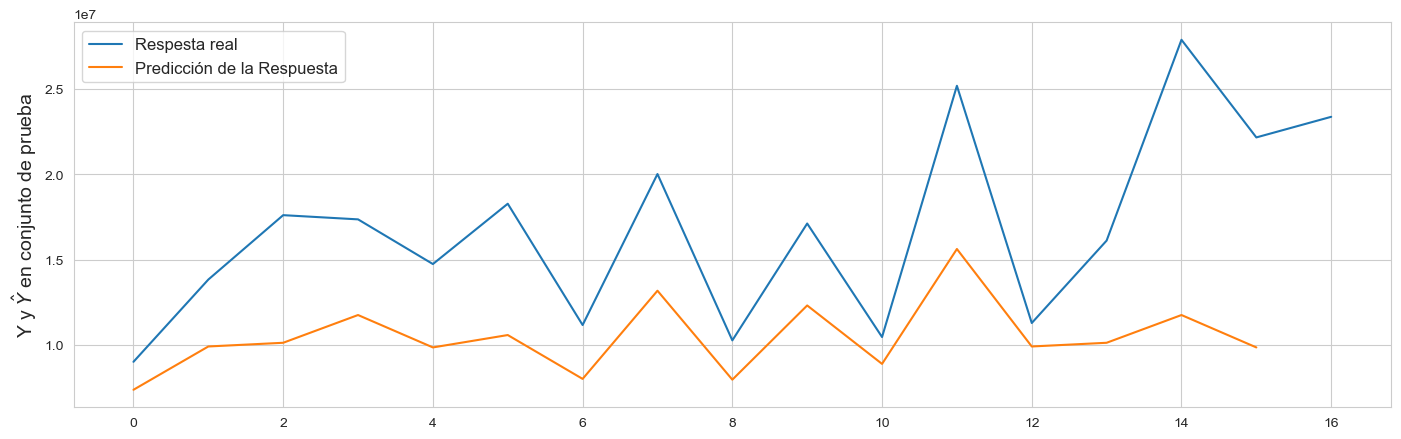

In [184]:
plt.plot(true_series_final)
plt.plot(prediction_test_final[:16])
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

El valor obtenido para el **RECM** para el modelo red neuronal multicapa fue de **$7659253.864895197$**

## LSTM

Ahora procederemos a utilizar el modelo de red recurrente sobre los datos originales, teniendo en cuenta que la series presenta una componente de tendencia. En primer lugar buscaremos los mejores hiperparametros para realizar nuestro modelamiento.

In [96]:
## ventana teniendo los datos originales y para 12 rezagos.
single_step_window = WindowGenerator(
    input_width=12, label_width=1, shift=1, ##Input_width me dice los retardos que quiero tener en cuenta por ende lo voy a cambiar por 12
    label_columns=['Impuestos'])# La variable a predecir es Impuestos
single_step_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12]
Label column name(s): ['Impuestos']

In [97]:
def build_model1(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('input_unit',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"]),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(layers.LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"]),return_sequences=True))
    model.add(layers.LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"])))
    model.add(layers.Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [98]:
tf.random.set_seed(123)
tuner_LSTM = kt.BayesianOptimization( #Aqui coloque BayesianOptimization en vez de RandomSearch
    hypermodel=build_model1,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [99]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=0)

In [100]:
tuner_LSTM.search_space_summary()

Search space summary
Default search space size: 6
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_2_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [101]:
tf.random.set_seed(123)
tuner_LSTM.search((single_step_window.train), epochs=10, validation_data=(single_step_window.val),callbacks=[stop_early])

Trial 3 Complete [00h 00m 18s]
val_loss: 4.713757038116455

Best val_loss So Far: 0.9353307485580444
Total elapsed time: 00h 00m 43s


In [102]:
# Get the top 2 models.
models_LSTM = tuner_LSTM.get_best_models(num_models=2)
best_model_LSTM = models_LSTM[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model_LSTM.build(input_shape=(128, 12, 1)) ## Preguntar si en el espacio de enmedio va un 12 o va un 1 teniendo en cuenta que estoy tomando 12 retardos
best_model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (128, 12, 160)            103680    
                                                                 
 lstm_1 (LSTM)               (128, 12, 64)             57600     
                                                                 
 lstm_2 (LSTM)               (128, 12, 32)             12416     
                                                                 
 lstm_3 (LSTM)               (128, 12, 32)             8320      
                                                                 
 lstm_4 (LSTM)               (128, 288)                369792    
                                                                 
 dropout (Dropout)           (128, 288)                0         
                                                                 
 dense (Dense)               (128, 1)                  2

In [103]:
tuner_LSTM.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
input_unit: 160
activation: tanh
n_layers: 3
lstm_0_units: 64
layer_2_neurons: 288
Dropout_rate: 0.0
lstm_1_units: 32
lstm_2_units: 32
Score: 0.9353307485580444

Trial 1 summary
Hyperparameters:
input_unit: 64
activation: relu
n_layers: 3
lstm_0_units: 192
layer_2_neurons: 32
Dropout_rate: 0.2
lstm_1_units: 64
lstm_2_units: 480
Score: 2.453261613845825

Trial 2 summary
Hyperparameters:
input_unit: 352
activation: relu
n_layers: 4
lstm_0_units: 192
layer_2_neurons: 224
Dropout_rate: 0.30000000000000004
lstm_1_units: 480
lstm_2_units: 224
lstm_3_units: 32
Score: 4.713757038116455


In [104]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)

In [105]:
# Get the top 2 hyperparameters.
best_hps_LSTM = tuner_LSTM.get_best_hyperparameters(5)
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=0)
model_LSTM = build_model(best_hps_LSTM[0])
# Fit with the entire dataset.
model_LSTM.fit(train_plus_val, epochs=10,callbacks=[callback])

Epoch 1/10
3/3 [==============================] - 1s 18ms/step - loss: 1.3786 - mean_squared_error: 1.3786
Epoch 2/10
3/3 [==============================] - 0s 14ms/step - loss: 1.3545 - mean_squared_error: 1.3545
Epoch 3/10
3/3 [==============================] - 0s 15ms/step - loss: 1.3324 - mean_squared_error: 1.3324
Epoch 4/10
3/3 [==============================] - 0s 15ms/step - loss: 1.3105 - mean_squared_error: 1.3105
Epoch 5/10
3/3 [==============================] - 0s 15ms/step - loss: 1.2890 - mean_squared_error: 1.2890
Epoch 6/10
3/3 [==============================] - 0s 14ms/step - loss: 1.2681 - mean_squared_error: 1.2681
Epoch 7/10
3/3 [==============================] - 0s 19ms/step - loss: 1.2476 - mean_squared_error: 1.2476
Epoch 8/10
3/3 [==============================] - 0s 18ms/step - loss: 1.2277 - mean_squared_error: 1.2277
Epoch 9/10
3/3 [==============================] - 0s 17ms/step - loss: 1.2083 - mean_squared_error: 1.2083
Epoch 10/10
3/3 [====================

In [106]:
model_LSTM.predict(single_step_window.test, verbose=0)

array([[[0.32724905],
        [0.6233375 ],
        [0.64156735],
        [0.75314575],
        [0.61852795],
        [0.67680424],
        [0.41749465],
        [0.824779  ],
        [0.41139686],
        [0.7835954 ],
        [0.5238499 ],
        [0.9159135 ]],

       [[0.6233375 ],
        [0.64156735],
        [0.75314575],
        [0.61852795],
        [0.67680424],
        [0.41749465],
        [0.824779  ],
        [0.41139686],
        [0.7835954 ],
        [0.5238499 ],
        [0.9159135 ],
        [0.48443973]],

       [[0.64156735],
        [0.75314575],
        [0.61852795],
        [0.67680424],
        [0.41749465],
        [0.824779  ],
        [0.41139686],
        [0.7835954 ],
        [0.5238499 ],
        [0.9159135 ],
        [0.48443973],
        [0.7525147 ]],

       [[0.75314575],
        [0.61852795],
        [0.67680424],
        [0.41749465],
        [0.824779  ],
        [0.41139686],
        [0.7835954 ],
        [0.5238499 ],
        [0.9159135 ],
    

In [107]:
model_LSTM.evaluate(single_step_window.test, verbose=0)

[15.658206939697266, 15.65820598602295]

In [108]:
prediction_test_LSTM=(model_LSTM.predict(single_step_window.test, verbose=1)*train_std['Impuestos']+train_mean['Impuestos'])

1/1 [==============================] - 0s 63ms/step


In [109]:
print(prediction_test_LSTM.shape)
print(prediction_test_LSTM)

(17, 12, 1)
[[[5458973.5]
  [6320795.5]
  [6373857. ]
  [6698627. ]
  [6306796. ]
  [6476420.5]
  [5721650.5]
  [6907129. ]
  [5703902. ]
  [6787256.5]
  [6031218. ]
  [7172393.5]]

 [[6320795.5]
  [6373857. ]
  [6698627. ]
  [6306796. ]
  [6476420.5]
  [5721650.5]
  [6907129. ]
  [5703902. ]
  [6787256.5]
  [6031218. ]
  [7172393.5]
  [5916507. ]]

 [[6373857. ]
  [6698627. ]
  [6306796. ]
  [6476420.5]
  [5721650.5]
  [6907129. ]
  [5703902. ]
  [6787256.5]
  [6031218. ]
  [7172393.5]
  [5916507. ]
  [6696790. ]]

 [[6698627. ]
  [6306796. ]
  [6476420.5]
  [5721650.5]
  [6907129. ]
  [5703902. ]
  [6787256.5]
  [6031218. ]
  [7172393.5]
  [5916507. ]
  [6696790. ]
  [7034095.5]]

 [[6306796. ]
  [6476420.5]
  [5721650.5]
  [6907129. ]
  [5703902. ]
  [6787256.5]
  [6031218. ]
  [7172393.5]
  [5916507. ]
  [6696790. ]
  [7034095.5]
  [7015921. ]]

 [[6476420.5]
  [5721650.5]
  [6907129. ]
  [5703902. ]
  [6787256.5]
  [6031218. ]
  [7172393.5]
  [5916507. ]
  [6696790. ]
  [7034095.5

In [110]:
i=1
for batch in target_dataset_test.take(1):
    if i==1:
        targets_test_LSTM = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1

In [112]:
print(targets_test.shape)
true_series_LSTM=targets_test*train_std['Impuestos']+train_mean['Impuestos']
true_series_LSTM=true_series.reshape((17,1,1))
print(true_series.shape)


(17, 1, 1)
(17, 1, 1)


In [113]:
errors_squared_LSTL=tf.keras.metrics.mean_squared_error(true_series_LSTM, prediction_test_LSTM).numpy()
print("RECM:",errors_squared_LSTL.mean()**0.5)

RECM: 11517732.41326955


In [115]:
test_index=test_df.index[:17]
test_index.values

array(['2021-02-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2021-05-01T00:00:00.000000000',
       '2021-06-01T00:00:00.000000000', '2021-07-01T00:00:00.000000000',
       '2021-08-01T00:00:00.000000000', '2021-09-01T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
       '2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2022-03-01T00:00:00.000000000',
       '2022-04-01T00:00:00.000000000', '2022-05-01T00:00:00.000000000',
       '2022-06-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [117]:
true_series_final_LSTL=true_series_LSTM.reshape(17)
prediction_test_final_LSTL=prediction_test_LSTM.reshape(204)

In [118]:
true_series_final_LSTL

array([ 9006955., 13829999., 17606762., 17359860., 14739749., 18276784.,
       11163888., 20018432., 10264124., 17116670., 10459926., 25192324.,
       11282248., 16115744., 27890912., 22164992., 23373604.],
      dtype=float32)

Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

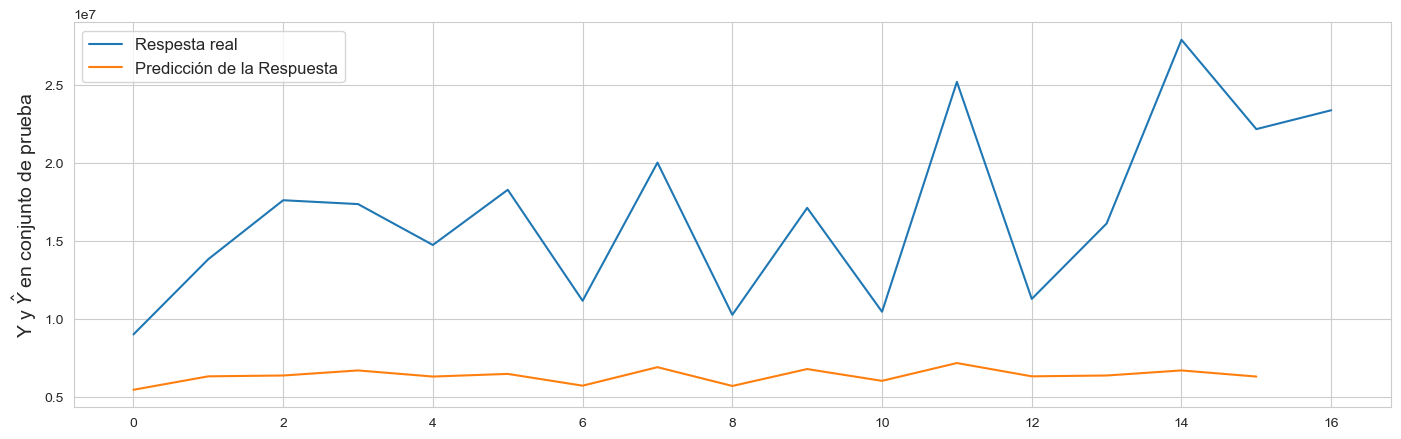

In [119]:
plt.plot(true_series_final_LSTL)
plt.plot(prediction_test_final_LSTL[:16])
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

El valor obtenido para el **RECM** para el modelo red neuronal multicapa fue de **$11517732.41326955$**